In [1]:
"""Modified Laura's code for internal variability
"""
import os
import sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import tqdm
# from tqdm import tqdm
from functools import partial
import json
import tensorflow as tf
from tensorflow.keras import layers
# AUTOTUNE = tf.data.experimental.AUTOTUNE
from dask.diagnostics import ProgressBar
import pathlib


2025-08-11 23:35:45.454082: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2025-08-11 23:36:03.410036: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-11 23:36:03.417594: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2025-08-11 23:36:03.425650: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:18:00.0 name: NVIDIA Tesla P100-PCIE-12GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 511.41GiB/s
2025-08-11 23:36:03.425676: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2025-08-11 23:36:03.714684: I tensorflow/stream_executor/platform/de

True

In [3]:

GAN_flag = True
variable = "pr"
input_data_path_base = "/nesi/project/niwa03712/CMIP6_data/Downscaled_Preprocessed"
gcm = "ACCESS-CM2"
ssp = "ssp370"
variant = "r4i1p1f1"
output_path_setup = "/nesi/nobackup/niwa00018/ML_Downscaled_CMIP6/"
emulator_type = "perfect_emulator"
code_dir = "/nesi/project/niwa03712/queenle/ML_emulator"

sys.path.append(f'{code_dir}/code/applying_ml_model/v3')
os.chdir(code_dir)
#try:
from src.util_functions import *
sys.path.append(f'/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/multi-variate-gan/')
from src.layers import *
from src.models import *
from src.gan import *

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:


configs = {"sfcWind": "NIWA-REMS_sfcWind_v050425",
           "sfcWindmax": "NIWA-REMS_sfcWindmax_v050425",
           "tasmax": "NIWA-REMS_tasmax_v050425",
           "tasmin": "NIWA-REMS_tasmin_v050425",
           "pr": "NIWA-REMS_pr_v050425"}
    
method = 'basic' # method of preprocessing input data
'''
Define config file and directories
'''
framework = "imperfect"
# define directories
ground_truth_dir = '/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/multi-variate-gan/inputs/'

print('BEGINNING EMULATOR DOWNSCALING')
# Loading up the minimum value dataset
print('Variable: ' + variable + os.getcwd())
ml_model_name = configs[variable]
print(f"current path: {os.getcwd()}, code_dir: {code_dir}")
min_value = None#xr.open_dataset(r'./models/' + ml_model_name + '/min_value_outputs.nc')


BEGINNING EMULATOR DOWNSCALING
Variable: pr/scale_wlg_persistent/filesets/project/niwa03712/queenle/ML_emulator
current path: /scale_wlg_persistent/filesets/project/niwa03712/queenle/ML_emulator, code_dir: /nesi/project/niwa03712/queenle/ML_emulator


In [5]:
print(input_data_path_base, gcm, ssp,
                                    variant, output_path_setup, variable, configs)
input_file2, output_path = get_files(input_data_path_base, gcm, ssp,
                                    variant, output_path_setup, variable, configs)

/nesi/project/niwa03712/CMIP6_data/Downscaled_Preprocessed ACCESS-CM2 ssp370 r4i1p1f1 /nesi/nobackup/niwa00018/ML_Downscaled_CMIP6/ pr {'sfcWind': 'NIWA-REMS_sfcWind_v050425', 'sfcWindmax': 'NIWA-REMS_sfcWindmax_v050425', 'tasmax': 'NIWA-REMS_tasmax_v050425', 'tasmin': 'NIWA-REMS_tasmin_v050425', 'pr': 'NIWA-REMS_pr_v050425'}


In [6]:
input_file2

'/nesi/project/niwa03712/CMIP6_data/Downscaled_Preprocessed/ScenarioMIP/CSIRO-ARCCSS/ACCESS-CM2/ssp370/r4i1p1f1/day/ScenarioMIP_CSIRO-ARCCSS_ACCESS-CM2_ssp370_r4i1p1f1_day_gn_v20210712.nc'

In [8]:
ml_model_name = 'NIWA-REMS_v110425_pr'

In [12]:
# df2 = xr.open_dataset(r'/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/GCM_emulator/model00_exp0000.daily.nc').rename({"lev":"plev"})

In [15]:
model_dir ='/nesi/project/niwa03712/queenle/ML_emulator/models/'
#model_dir = './models/'
#ml_model_name ='/new_model_v8_04_25_ACCESS-CM2_0.005pr_ACCESS-CM2_0.01pr_ACCESS-CM2/'
generator, unet_model = load_model(ml_model_name, model_dir)

2025-08-11 23:37:22.442798: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:18:00.0 name: NVIDIA Tesla P100-PCIE-12GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 511.41GiB/s
2025-08-11 23:37:22.443670: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2025-08-11 23:37:22.444319: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:18:00.0 name: NVIDIA Tesla P100-PCIE-12GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 511.41GiB/s
2025-08-11 23:37:22.445054: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2025-08-11 23:37:22.445083: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2025-08-11 23:37:22.445088: I t

In [16]:

def convert_file(path):
    df2 = xr.open_dataset(path).rename({"lev":"plev"})
    df2 = df2.sel(time = slice("2095","2100"))
    df2.to_netcdf(path.replace(".nc","_updated.nc"))
input_file = r'/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/GCM_emulator/model00_exp0000.daily_v2.nc'
df2 = xr.open_dataset(input_file2)

In [17]:
# config['train_x']

In [18]:
# df = xr.open_dataset(r'/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/GCM_emulator/data/model00_exp0000.daily_u.nc')

In [19]:
# plt.plot(df.ta.isel( plev =1).mean(["lat","lon"]).values)#.plot()

In [23]:
config = {'train_y': '/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/multi-variate-gan/inputs/target_fields/target_fields_hist_ssp370_concat.nc',
 'stds_output': '/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/multi-variate-gan/inputs/normalization/target_spatial_norm_all_gcm_std.nc',
 'means_output': '/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/multi-variate-gan/inputs/normalization/target_spatial_norm_all_gcm_mean.nc',
 'mean': '/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/multi-variate-gan/inputs/normalization/all_gcm_spatial_means.nc',
 'std': '/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/multi-variate-gan/inputs/normalization/all_gcm_spatial_stds.nc',
 'train_x': '/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/multi-variate-gan/inputs/predictor_fields/predictor_fields_hist_ssp370_merged_updated.nc',
 'src_path': '/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/multi-variate-gan',
 'var_names': ['q_500',
  'q_850',
  'u_500',
  'u_850',
  'v_500',
  'v_850',
  't_500',
  't_850'],
 'output_folder': '/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/On-the-Extrapolation-of-Generative-Adversarial-Networks-for-downscaling-precipitation-extremes/models',
 'model_name': 'NIWA-REMS_v110425_pr',
 'notes': 'Just trained on the ACCESS-CM2 gcm only, both historical and future training',
 'ad_loss_factor': 0.008,
 'n_filters': [16, 32, 64, 128],
 'kernel_size': 3,
 'n_input_channels': 8,
 'n_output_channels': 1,
 'output_shape': [172, 179],
 'input_shape': [23, 26],
 'learning_rate': 3e-05,
 'beta_1': 0.5,
 'beta_2': 0.9,
 'precip_conv_factor': 1,
 'log_beta': 3.5,
 'gan_model_fine_tuning': 'None',
 'd_model_fine_tuning': 'None',
 'fine_tuning': 'False',
 'latent_loss': 0.05,
 'gp_weight': 10,
 'discrim_steps': 3,
 'static_predictors': '/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/training_GAN/ancil_fields/ERA5_eval_ccam_12km.198110_NZ_Invariant.nc',
 'learning_rate_unet': 0.0001,
 'decay_steps': 1000,
 'decay_rate_gan': 0.9942,
 'decay_rate': 0.9962,
 'batch_size': 16,
 'epochs': 200,
 'norm': 'log',
 'delta': 1,
 'preloaded': 0.0,
 'gcms_for_training_GAN': ['ACCESS-CM2'],
 'itensity_weight': 1.25,
 'output_varname': 'pr',
 'period_start': '1970',
 'av_int_weight': 0.25,
 'conversion_factor': 86400,
 'input_means_means': '/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/multi-variate-gan/inputs/normalization/feature_means_mean.nc',
 'input_means_stds': '/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/multi-variate-gan/inputs/normalization/feature_means_std.nc',
 'input_stds_stds': '/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/multi-variate-gan/inputs/normalization/feature_stds_std.nc',
 'input_stds_means': '/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/multi-variate-gan/inputs/normalization/feature_stds_mean.nc'}

In [53]:
df_era5 = xr.open_dataset(r'/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/GCM_emulator/ERA5_remapped_con_v2.nc')

In [54]:
df_era5 = df_era5.rename({"latitude":"lat","longitude":"lon"})

In [55]:

df_era5.to_netcdf(r'/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/GCM_emulator/ERA5_remapped_con_v3_lat_lon.nc')

In [79]:
df_change = xr.open_dataset(r'/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/GCM_emulator/ds_change_field.nc')

In [80]:
levels = [850, 500]
rename_dict = {"temp":"t","sphum":"q","ucomp":"u","vcomp":"v"}
df_change = df_change.rename(rename_dict)
for var in list(df_change.data_vars):
    for level in levels:
        df_change[f'{var}_{int(level)}'] = df_change[var].sel(level = level)
    df_change = df_change.drop({var})


In [81]:
df_change_interp = df_change.interp(lat = df_era5.lat, lon = df_era5.lon, method ='linear', kwargs = dict(fill_value = 'extrapolate'))

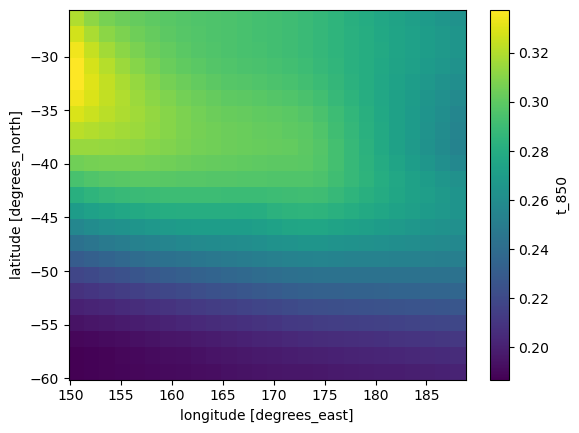

In [202]:
df_change_interp.t_850.plot()

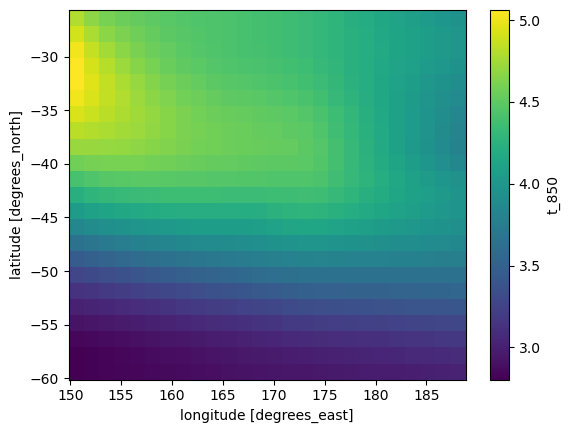

In [127]:
( df_change_interp.t_850 * 15).plot()

In [141]:
zs = []
for factor in range(1, 30, 5):
    adjusted_era5 = df_era5 + df_change_interp * factor
    z= 3.95/15 * factor
    zs.append(z)
    
    adjusted_era5.to_netcdf(f'/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/GCM_emulator/ERA5_remapped_con_v3_lat_lon_PSW_{int(3.9/15 * factor)}.nc')

In [206]:
adjusted_era5

<xarray.Dataset>
Dimensions:  (time: 1917, lon: 26, lat: 23, level: 11)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2025-03-31
  * lon      (lon) float64 150.6 152.1 153.6 155.1 ... 183.6 185.1 186.6 188.1
  * lat      (lat) float64 -59.38 -57.88 -56.38 -54.88 ... -29.38 -27.88 -26.38
  * level    (level) float64 1e+03 925.0 850.0 700.0 ... 300.0 250.0 200.0 150.0
Data variables:
    u_850    (time, lat, lon) float64 10.4 9.635 8.881 ... -4.059 -0.8522 2.521
    u_500    (time, lat, lon) float64 17.02 17.14 17.56 ... 7.066 7.509 9.176
    v_850    (time, lat, lon) float64 -4.822 -4.752 -5.494 ... 6.87 9.382 8.367
    v_500    (time, lat, lon) float64 -9.761 -10.25 -10.68 ... 9.097 8.038 5.98
    t_850    (time, lat, lon) float64 273.2 273.7 274.8 ... 292.6 293.0 293.2
    t_500    (time, lat, lon) float64 253.0 253.1 253.2 ... 274.5 272.9 272.1
    q_850    (time, lat, lon) float64 0.003774 0.003776 ... 0.009804 0.01006
    q_500    (time, lat, lon) float64 0.0005639 0.0006028 ... 0.001224 0.001471

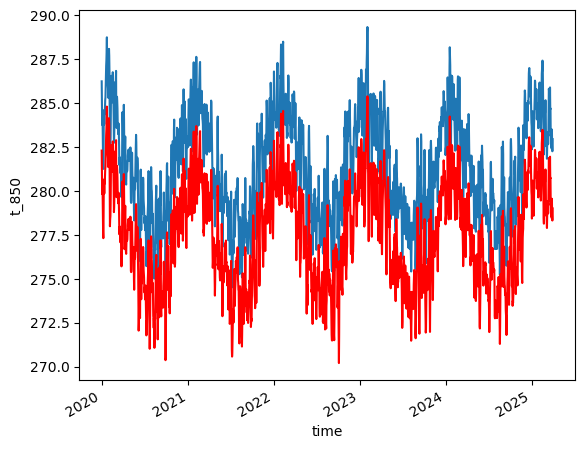

In [96]:
adjusted_era5.t_850.mean(["lat","lon"]).plot()
df_era5.t_850.mean(["lat","lon"]).plot(color ='r')



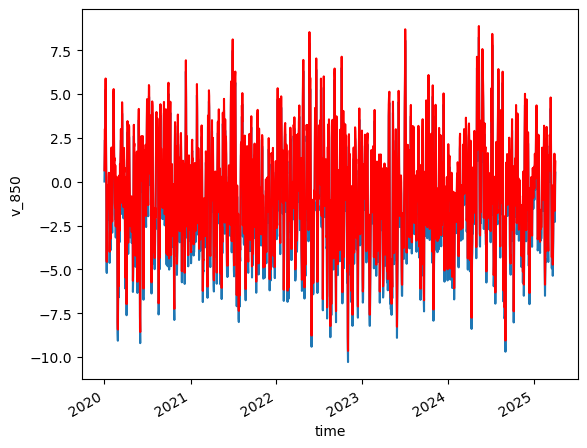

In [213]:
adjusted_era5.v_850.mean(["lat","lon"]).plot()
df_era5.v_850.mean(["lat","lon"]).plot(color ='r')



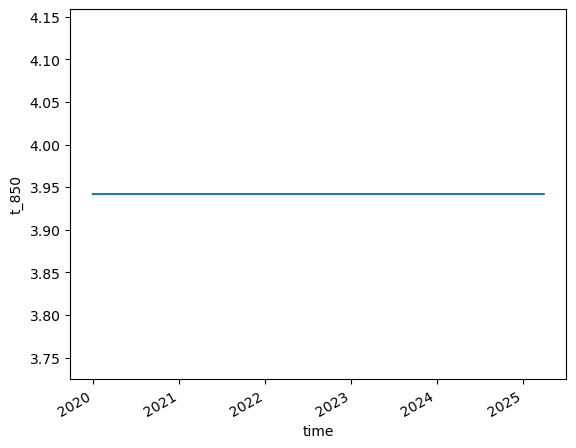

In [97]:
(adjusted_era5.t_850 - df_era5.t_850).mean(["lat","lon"]).plot()
#df_era5.t_850.mean(["lat","lon"]).plot(color ='r')

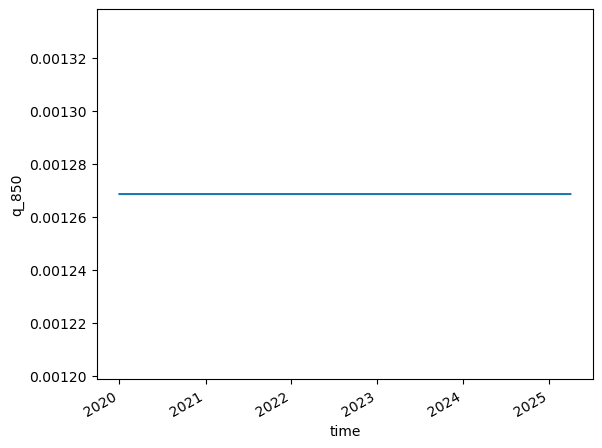

In [98]:
(adjusted_era5.q_850 - df_era5.q_850).mean(["lat","lon"]).plot()

In [ ]:
outputs_wind = []
for factor in [0, 1, 2, 4, 5, 6]:
    input_file2 = f'/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/GCM_emulator/ERA5_remapped_con_v3_lat_lon_PSW_{factor}.nc'
    framework = 'perfect'



    #config_file = model_dir + ml_model_name + '/config_info.json'
    # with open(config_file) as f:
    #     config = json.load(f)

    output_means = xr.open_dataset(config["means_output"])
    output_stds = xr.open_dataset(config["stds_output"])
    # LOAD ML MODEL
    print('LOAD ML MODEL\n')

    # PREP INPUT
    print('\nPREP INPUT')
    ml_model_name2 = configs["sfcWind"]
    variable1 ="sfcWindmax"
    ml_model_name2 = configs[variable1]
    processed_GCM_data, mean_data, variance_data, vegt, orog, he, time_of_year = prepare_ML_inputs(input_file2, config,
                                                                                                   framework, method = method)
    #ml_model_name = 'NIWA-REMS_v110425_pr'
    generator, unet_model = load_model(ml_model_name2, model_dir)
    with ProgressBar():
        mean_data = mean_data.load()
        variance_data = variance_data.load()
        processed_GCM_data = processed_GCM_data.load()
        time_of_year = time_of_year.load()
        print(mean_data, time_of_year)
        print('PREP OUTPUT')
    output_shape = initialize_output_ds(processed_GCM_data, config)
    output_shape = output_shape.rename({"pr": variable})
    print('APPLY ML MODEL')
    ts = slice("2023","2024")
    output2 = predict_parallel_resid_corrector_v5varname(generator, unet_model,
                                                        processed_GCM_data.transpose('time', 'lat', 'lon',
                                                                                     'channel').sel(time = ts).values, \
                                                        output_shape.sel(time = ts), 64, orog, output_means, output_stds, time_of_year.sel(time = ts), \
                                                        mean_data.sel(time = ts).transpose('time', 'channel'),
                                                        variance_data.sel(time = ts).transpose('time', 'channel'), gan=GAN_flag, \
                                                        min_value=min_value, varname=variable1)
    outputs_wind.append(output2)

LOAD ML MODEL


PREP INPUT
[########################################] | 100% Completed | 101.96 ms
	- processing GCM input data
		- normalizing by mean and standard deviation
		- concatenating variables to channel dimension
	- processing mean, variance, and time data
	- processing static fields
	- calculating time of year array
<xarray.DataArray 'q_500' (channel: 8, time: 1917)>
array([[ 0.14902065, -0.18693635,  0.10239446, ...,  0.62751658,
         0.23280127,  0.58992421],
       [-0.16101216, -0.32592587, -0.70145842, ...,  0.67549199,
         0.65737952,  0.67917533],
       [-0.39501031, -0.61901656, -0.45978502, ...,  0.05137656,
         0.0673063 , -0.10906762],
       ...,
       [ 0.28553696,  0.70873734,  1.05233202, ..., -0.45946815,
         0.22164888,  0.44916081],
       [ 0.91150533,  0.60508487,  0.42910362, ...,  0.38255183,
         0.29690352,  0.65547974],
       [ 1.37648022,  0.99545547,  0.65292657, ...,  0.32027002,
         0.21445995,  0.41613714]])
Coord

Predicting: 100%|██████████| 11/11 [00:10<00:00,  1.01batch/s]


LOAD ML MODEL


PREP INPUT
[########################################] | 100% Completed | 102.22 ms
	- processing GCM input data
		- normalizing by mean and standard deviation
		- concatenating variables to channel dimension
	- processing mean, variance, and time data
	- processing static fields
	- calculating time of year array
<xarray.DataArray 'q_500' (channel: 8, time: 1917)>
array([[ 0.52990839,  0.19395139,  0.4832822 , ...,  1.00840432,
         0.61368901,  0.97081195],
       [ 0.26833933,  0.10342562, -0.27210692, ...,  1.10484349,
         1.08673102,  1.10852682],
       [-0.26432105, -0.48832731, -0.32909576, ...,  0.18206582,
         0.19799556,  0.02162164],
       ...,
       [ 0.2459432 ,  0.66914358,  1.01273826, ..., -0.49906191,
         0.18205512,  0.40956705],
       [ 1.34490987,  1.0384894 ,  0.86250815, ...,  0.81595637,
         0.73030806,  1.08888428],
       [ 1.76004696,  1.37902221,  1.03649331, ...,  0.70383676,
         0.59802669,  0.79970388]])
Coord

Predicting: 100%|██████████| 11/11 [00:10<00:00,  1.01batch/s]


LOAD ML MODEL


PREP INPUT
[########################################] | 100% Completed | 101.76 ms
	- processing GCM input data
		- normalizing by mean and standard deviation
		- concatenating variables to channel dimension
	- processing mean, variance, and time data
	- processing static fields
	- calculating time of year array
<xarray.DataArray 'q_500' (channel: 8, time: 1917)>
array([[ 0.91079614,  0.57483913,  0.86416994, ...,  1.38929206,
         0.99457675,  1.35169969],
       [ 0.69769083,  0.53277712,  0.15724457, ...,  1.53419499,
         1.51608252,  1.53787832],
       [-0.13363179, -0.35763805, -0.1984065 , ...,  0.31275507,
         0.32868482,  0.1523109 ],
       ...,
       [ 0.20634944,  0.62954981,  0.9731445 , ..., -0.53865567,
         0.14246136,  0.36997329],
       [ 1.7783144 ,  1.47189394,  1.29591268, ...,  1.2493609 ,
         1.16371259,  1.52228881],
       [ 2.1436137 ,  1.76258895,  1.42006005, ...,  1.0874035 ,
         0.98159343,  1.18327062]])
Coord

Predicting: 100%|██████████| 11/11 [00:10<00:00,  1.02batch/s]


LOAD ML MODEL


PREP INPUT
[########################################] | 100% Completed | 101.82 ms
	- processing GCM input data
		- normalizing by mean and standard deviation
		- concatenating variables to channel dimension
	- processing mean, variance, and time data
	- processing static fields
	- calculating time of year array
<xarray.DataArray 'q_500' (channel: 8, time: 1917)>
array([[ 1.29168388,  0.95572688,  1.24505768, ...,  1.7701798 ,
         1.37546449,  1.73258743],
       [ 1.12704232,  0.96212862,  0.58659607, ...,  1.96354648,
         1.94543401,  1.96722981],
       [-0.00294253, -0.22694879, -0.06771724, ...,  0.44344433,
         0.45937407,  0.28300016],
       ...,
       [ 0.16675568,  0.58995605,  0.93355073, ..., -0.57824943,
         0.1028676 ,  0.33037953],
       [ 2.21171893,  1.90529847,  1.72931722, ...,  1.68276544,
         1.59711713,  1.95569334],
       [ 2.52718044,  2.14615569,  1.80362679, ...,  1.47097024,
         1.36516017,  1.56683736]])
Coord

Predicting: 100%|██████████| 11/11 [00:12<00:00,  1.11s/batch]


LOAD ML MODEL


PREP INPUT
[########################################] | 100% Completed | 101.74 ms
	- processing GCM input data
		- normalizing by mean and standard deviation
		- concatenating variables to channel dimension
	- processing mean, variance, and time data
	- processing static fields
	- calculating time of year array
<xarray.DataArray 'q_500' (channel: 8, time: 1917)>
array([[ 1.67257162,  1.33661462,  1.62594542, ...,  2.15106754,
         1.75635223,  2.11347517],
       [ 1.55639382,  1.39148011,  1.01594757, ...,  2.39289798,
         2.37478551,  2.39658131],
       [ 0.12774672, -0.09625953,  0.06297202, ...,  0.57413359,
         0.59006333,  0.41368942],
       ...,
       [ 0.12716192,  0.55036229,  0.89395697, ..., -0.61784319,
         0.06327384,  0.29078576],
       [ 2.64512347,  2.338703  ,  2.16272175, ...,  2.11616997,
         2.03052166,  2.38909788],
       [ 2.91074718,  2.52972243,  2.18719353, ...,  1.85453698,
         1.74872691,  1.9504041 ]])
Coord

Predicting: 100%|██████████| 11/11 [00:11<00:00,  1.00s/batch]


In [218]:
outputs_wind = xr.concat(outputs_wind, dim = "warming")

In [222]:
outputs_temp = []
for factor in [0, 1, 2, 4, 5, 6]:
    input_file2 = f'/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/GCM_emulator/ERA5_remapped_con_v3_lat_lon_PSW_{factor}.nc'
    framework = 'perfect'



    #config_file = model_dir + ml_model_name + '/config_info.json'
    # with open(config_file) as f:
    #     config = json.load(f)

    output_means = xr.open_dataset(config["means_output"])
    output_stds = xr.open_dataset(config["stds_output"])
    # LOAD ML MODEL
    print('LOAD ML MODEL\n')

    # PREP INPUT
    print('\nPREP INPUT')
    variable1 ="tasmax"
    ml_model_name2 = configs[variable1]
    
    processed_GCM_data, mean_data, variance_data, vegt, orog, he, time_of_year = prepare_ML_inputs(input_file2, config,
                                                                                                   framework, method = method)
    #ml_model_name = 'NIWA-REMS_v110425_pr'
    generator, unet_model = load_model(ml_model_name2, model_dir)
    with ProgressBar():
        mean_data = mean_data.load()
        variance_data = variance_data.load()
        processed_GCM_data = processed_GCM_data.load()
        time_of_year = time_of_year.load()
        print(mean_data, time_of_year)
        print('PREP OUTPUT')
    output_shape = initialize_output_ds(processed_GCM_data, config)
    output_shape = output_shape.rename({"pr": variable})
    print('APPLY ML MODEL')
    ts = slice("2023","2024")
    output2 = predict_parallel_resid_corrector_v5varname(generator, unet_model,
                                                        processed_GCM_data.transpose('time', 'lat', 'lon',
                                                                                     'channel').sel(time = ts).values, \
                                                        output_shape.sel(time = ts), 64, orog, output_means, output_stds, time_of_year.sel(time = ts), \
                                                        mean_data.sel(time = ts).transpose('time', 'channel'),
                                                        variance_data.sel(time = ts).transpose('time', 'channel'), gan=GAN_flag, \
                                                        min_value=min_value, varname=variable1)
    outputs_temp.append(output2)

LOAD ML MODEL


PREP INPUT
[########################################] | 100% Completed | 102.34 ms
	- processing GCM input data
		- normalizing by mean and standard deviation
		- concatenating variables to channel dimension
	- processing mean, variance, and time data
	- processing static fields
	- calculating time of year array
<xarray.DataArray 'q_500' (channel: 8, time: 1917)>
array([[ 0.14902065, -0.18693635,  0.10239446, ...,  0.62751658,
         0.23280127,  0.58992421],
       [-0.16101216, -0.32592587, -0.70145842, ...,  0.67549199,
         0.65737952,  0.67917533],
       [-0.39501031, -0.61901656, -0.45978502, ...,  0.05137656,
         0.0673063 , -0.10906762],
       ...,
       [ 0.28553696,  0.70873734,  1.05233202, ..., -0.45946815,
         0.22164888,  0.44916081],
       [ 0.91150533,  0.60508487,  0.42910362, ...,  0.38255183,
         0.29690352,  0.65547974],
       [ 1.37648022,  0.99545547,  0.65292657, ...,  0.32027002,
         0.21445995,  0.41613714]])
Coord

Predicting: 100%|██████████| 11/11 [00:11<00:00,  1.00s/batch]


LOAD ML MODEL


PREP INPUT
[########################################] | 100% Completed | 102.21 ms
	- processing GCM input data
		- normalizing by mean and standard deviation
		- concatenating variables to channel dimension
	- processing mean, variance, and time data
	- processing static fields
	- calculating time of year array
<xarray.DataArray 'q_500' (channel: 8, time: 1917)>
array([[ 0.52990839,  0.19395139,  0.4832822 , ...,  1.00840432,
         0.61368901,  0.97081195],
       [ 0.26833933,  0.10342562, -0.27210692, ...,  1.10484349,
         1.08673102,  1.10852682],
       [-0.26432105, -0.48832731, -0.32909576, ...,  0.18206582,
         0.19799556,  0.02162164],
       ...,
       [ 0.2459432 ,  0.66914358,  1.01273826, ..., -0.49906191,
         0.18205512,  0.40956705],
       [ 1.34490987,  1.0384894 ,  0.86250815, ...,  0.81595637,
         0.73030806,  1.08888428],
       [ 1.76004696,  1.37902221,  1.03649331, ...,  0.70383676,
         0.59802669,  0.79970388]])
Coord

Predicting: 100%|██████████| 11/11 [00:11<00:00,  1.01s/batch]


LOAD ML MODEL


PREP INPUT
[########################################] | 100% Completed | 102.11 ms
	- processing GCM input data
		- normalizing by mean and standard deviation
		- concatenating variables to channel dimension
	- processing mean, variance, and time data
	- processing static fields
	- calculating time of year array
<xarray.DataArray 'q_500' (channel: 8, time: 1917)>
array([[ 0.91079614,  0.57483913,  0.86416994, ...,  1.38929206,
         0.99457675,  1.35169969],
       [ 0.69769083,  0.53277712,  0.15724457, ...,  1.53419499,
         1.51608252,  1.53787832],
       [-0.13363179, -0.35763805, -0.1984065 , ...,  0.31275507,
         0.32868482,  0.1523109 ],
       ...,
       [ 0.20634944,  0.62954981,  0.9731445 , ..., -0.53865567,
         0.14246136,  0.36997329],
       [ 1.7783144 ,  1.47189394,  1.29591268, ...,  1.2493609 ,
         1.16371259,  1.52228881],
       [ 2.1436137 ,  1.76258895,  1.42006005, ...,  1.0874035 ,
         0.98159343,  1.18327062]])
Coord

Predicting: 100%|██████████| 11/11 [00:11<00:00,  1.01s/batch]


LOAD ML MODEL


PREP INPUT
[########################################] | 100% Completed | 102.57 ms
	- processing GCM input data
		- normalizing by mean and standard deviation
		- concatenating variables to channel dimension
	- processing mean, variance, and time data
	- processing static fields
	- calculating time of year array
<xarray.DataArray 'q_500' (channel: 8, time: 1917)>
array([[ 1.29168388,  0.95572688,  1.24505768, ...,  1.7701798 ,
         1.37546449,  1.73258743],
       [ 1.12704232,  0.96212862,  0.58659607, ...,  1.96354648,
         1.94543401,  1.96722981],
       [-0.00294253, -0.22694879, -0.06771724, ...,  0.44344433,
         0.45937407,  0.28300016],
       ...,
       [ 0.16675568,  0.58995605,  0.93355073, ..., -0.57824943,
         0.1028676 ,  0.33037953],
       [ 2.21171893,  1.90529847,  1.72931722, ...,  1.68276544,
         1.59711713,  1.95569334],
       [ 2.52718044,  2.14615569,  1.80362679, ...,  1.47097024,
         1.36516017,  1.56683736]])
Coord

Predicting: 100%|██████████| 11/11 [00:10<00:00,  1.02batch/s]


LOAD ML MODEL


PREP INPUT
[########################################] | 100% Completed | 102.20 ms
	- processing GCM input data
		- normalizing by mean and standard deviation
		- concatenating variables to channel dimension
	- processing mean, variance, and time data
	- processing static fields
	- calculating time of year array
<xarray.DataArray 'q_500' (channel: 8, time: 1917)>
array([[ 1.67257162,  1.33661462,  1.62594542, ...,  2.15106754,
         1.75635223,  2.11347517],
       [ 1.55639382,  1.39148011,  1.01594757, ...,  2.39289798,
         2.37478551,  2.39658131],
       [ 0.12774672, -0.09625953,  0.06297202, ...,  0.57413359,
         0.59006333,  0.41368942],
       ...,
       [ 0.12716192,  0.55036229,  0.89395697, ..., -0.61784319,
         0.06327384,  0.29078576],
       [ 2.64512347,  2.338703  ,  2.16272175, ...,  2.11616997,
         2.03052166,  2.38909788],
       [ 2.91074718,  2.52972243,  2.18719353, ...,  1.85453698,
         1.74872691,  1.9504041 ]])
Coord

Predicting: 100%|██████████| 11/11 [00:10<00:00,  1.03batch/s]


LOAD ML MODEL


PREP INPUT
[########################################] | 100% Completed | 102.11 ms
	- processing GCM input data
		- normalizing by mean and standard deviation
		- concatenating variables to channel dimension
	- processing mean, variance, and time data
	- processing static fields
	- calculating time of year array
<xarray.DataArray 'q_500' (channel: 8, time: 1917)>
array([[ 2.05345936,  1.71750236,  2.00683316, ...,  2.53195529,
         2.13723998,  2.49436291],
       [ 1.98574532,  1.82083161,  1.44529906, ...,  2.82224947,
         2.80413701,  2.82593281],
       [ 0.25843598,  0.03442973,  0.19366128, ...,  0.70482285,
         0.72075259,  0.54437867],
       ...,
       [ 0.08756816,  0.51076853,  0.85436321, ..., -0.65743695,
         0.02368008,  0.251192  ],
       [ 3.078528  ,  2.77210754,  2.59612629, ...,  2.5495745 ,
         2.46392619,  2.82250241],
       [ 3.29431392,  2.91328917,  2.57076027, ...,  2.23810372,
         2.13229365,  2.33397084]])
Coord

Predicting: 100%|██████████| 11/11 [00:10<00:00,  1.03batch/s]


In [224]:
outputs_temp = xr.concat(outputs_temp, dim = "warming")

In [129]:
outputs = []
for factor in [0, 1, 2, 4, 5, 6]:
    input_file2 = f'/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/GCM_emulator/ERA5_remapped_con_v3_lat_lon_PSW_{factor}.nc'
    framework = 'perfect'



    #config_file = model_dir + ml_model_name + '/config_info.json'
    # with open(config_file) as f:
    #     config = json.load(f)

    output_means = xr.open_dataset(config["means_output"])
    output_stds = xr.open_dataset(config["stds_output"])
    # LOAD ML MODEL
    print('LOAD ML MODEL\n')

    # PREP INPUT
    print('\nPREP INPUT')
    processed_GCM_data, mean_data, variance_data, vegt, orog, he, time_of_year = prepare_ML_inputs(input_file2, config,
                                                                                                   framework, method = method)

    with ProgressBar():
        mean_data = mean_data.load()
        variance_data = variance_data.load()
        processed_GCM_data = processed_GCM_data.load()
        time_of_year = time_of_year.load()
        print(mean_data, time_of_year)
        print('PREP OUTPUT')
    output_shape = initialize_output_ds(processed_GCM_data, config)
    output_shape = output_shape.rename({"pr": variable})
    print('APPLY ML MODEL')
    ts = slice("2023","2024")
    output2 = predict_parallel_resid_corrector_v5varname(generator, unet_model,
                                                        processed_GCM_data.transpose('time', 'lat', 'lon',
                                                                                     'channel').sel(time = ts).values, \
                                                        output_shape.sel(time = ts), 64, orog, output_means, output_stds, time_of_year.sel(time = ts), \
                                                        mean_data.sel(time = ts).transpose('time', 'channel'),
                                                        variance_data.sel(time = ts).transpose('time', 'channel'), gan=GAN_flag, \
                                                        min_value=min_value, varname=variable)
    outputs.append(output2)

LOAD ML MODEL


PREP INPUT
[########################################] | 100% Completed | 102.00 ms
	- processing GCM input data
		- normalizing by mean and standard deviation
		- concatenating variables to channel dimension
	- processing mean, variance, and time data
	- processing static fields
	- calculating time of year array
<xarray.DataArray 'q_500' (channel: 8, time: 1917)>
array([[ 0.14902065, -0.18693635,  0.10239446, ...,  0.62751658,
         0.23280127,  0.58992421],
       [-0.16101216, -0.32592587, -0.70145842, ...,  0.67549199,
         0.65737952,  0.67917533],
       [-0.39501031, -0.61901656, -0.45978502, ...,  0.05137656,
         0.0673063 , -0.10906762],
       ...,
       [ 0.28553696,  0.70873734,  1.05233202, ..., -0.45946815,
         0.22164888,  0.44916081],
       [ 0.91150533,  0.60508487,  0.42910362, ...,  0.38255183,
         0.29690352,  0.65547974],
       [ 1.37648022,  0.99545547,  0.65292657, ...,  0.32027002,
         0.21445995,  0.41613714]])
Coord

Predicting: 100%|██████████| 11/11 [00:12<00:00,  1.15s/batch]


LOAD ML MODEL


PREP INPUT
[########################################] | 100% Completed | 102.08 ms
	- processing GCM input data
		- normalizing by mean and standard deviation
		- concatenating variables to channel dimension
	- processing mean, variance, and time data
	- processing static fields
	- calculating time of year array
<xarray.DataArray 'q_500' (channel: 8, time: 1917)>
array([[ 0.52990839,  0.19395139,  0.4832822 , ...,  1.00840432,
         0.61368901,  0.97081195],
       [ 0.26833933,  0.10342562, -0.27210692, ...,  1.10484349,
         1.08673102,  1.10852682],
       [-0.26432105, -0.48832731, -0.32909576, ...,  0.18206582,
         0.19799556,  0.02162164],
       ...,
       [ 0.2459432 ,  0.66914358,  1.01273826, ..., -0.49906191,
         0.18205512,  0.40956705],
       [ 1.34490987,  1.0384894 ,  0.86250815, ...,  0.81595637,
         0.73030806,  1.08888428],
       [ 1.76004696,  1.37902221,  1.03649331, ...,  0.70383676,
         0.59802669,  0.79970388]])
Coord

Predicting: 100%|██████████| 11/11 [00:12<00:00,  1.15s/batch]


LOAD ML MODEL


PREP INPUT
[########################################] | 100% Completed | 102.40 ms
	- processing GCM input data
		- normalizing by mean and standard deviation
		- concatenating variables to channel dimension
	- processing mean, variance, and time data
	- processing static fields
	- calculating time of year array
<xarray.DataArray 'q_500' (channel: 8, time: 1917)>
array([[ 0.91079614,  0.57483913,  0.86416994, ...,  1.38929206,
         0.99457675,  1.35169969],
       [ 0.69769083,  0.53277712,  0.15724457, ...,  1.53419499,
         1.51608252,  1.53787832],
       [-0.13363179, -0.35763805, -0.1984065 , ...,  0.31275507,
         0.32868482,  0.1523109 ],
       ...,
       [ 0.20634944,  0.62954981,  0.9731445 , ..., -0.53865567,
         0.14246136,  0.36997329],
       [ 1.7783144 ,  1.47189394,  1.29591268, ...,  1.2493609 ,
         1.16371259,  1.52228881],
       [ 2.1436137 ,  1.76258895,  1.42006005, ...,  1.0874035 ,
         0.98159343,  1.18327062]])
Coord

Predicting: 100%|██████████| 11/11 [00:12<00:00,  1.14s/batch]


LOAD ML MODEL


PREP INPUT
[########################################] | 100% Completed | 102.25 ms
	- processing GCM input data
		- normalizing by mean and standard deviation
		- concatenating variables to channel dimension
	- processing mean, variance, and time data
	- processing static fields
	- calculating time of year array
<xarray.DataArray 'q_500' (channel: 8, time: 1917)>
array([[ 1.29168388,  0.95572688,  1.24505768, ...,  1.7701798 ,
         1.37546449,  1.73258743],
       [ 1.12704232,  0.96212862,  0.58659607, ...,  1.96354648,
         1.94543401,  1.96722981],
       [-0.00294253, -0.22694879, -0.06771724, ...,  0.44344433,
         0.45937407,  0.28300016],
       ...,
       [ 0.16675568,  0.58995605,  0.93355073, ..., -0.57824943,
         0.1028676 ,  0.33037953],
       [ 2.21171893,  1.90529847,  1.72931722, ...,  1.68276544,
         1.59711713,  1.95569334],
       [ 2.52718044,  2.14615569,  1.80362679, ...,  1.47097024,
         1.36516017,  1.56683736]])
Coord

Predicting: 100%|██████████| 11/11 [00:12<00:00,  1.12s/batch]


LOAD ML MODEL


PREP INPUT
[########################################] | 100% Completed | 102.04 ms
	- processing GCM input data
		- normalizing by mean and standard deviation
		- concatenating variables to channel dimension
	- processing mean, variance, and time data
	- processing static fields
	- calculating time of year array
<xarray.DataArray 'q_500' (channel: 8, time: 1917)>
array([[ 1.67257162,  1.33661462,  1.62594542, ...,  2.15106754,
         1.75635223,  2.11347517],
       [ 1.55639382,  1.39148011,  1.01594757, ...,  2.39289798,
         2.37478551,  2.39658131],
       [ 0.12774672, -0.09625953,  0.06297202, ...,  0.57413359,
         0.59006333,  0.41368942],
       ...,
       [ 0.12716192,  0.55036229,  0.89395697, ..., -0.61784319,
         0.06327384,  0.29078576],
       [ 2.64512347,  2.338703  ,  2.16272175, ...,  2.11616997,
         2.03052166,  2.38909788],
       [ 2.91074718,  2.52972243,  2.18719353, ...,  1.85453698,
         1.74872691,  1.9504041 ]])
Coord

Predicting: 100%|██████████| 11/11 [00:12<00:00,  1.14s/batch]


LOAD ML MODEL


PREP INPUT
[########################################] | 100% Completed | 102.96 ms
	- processing GCM input data
		- normalizing by mean and standard deviation
		- concatenating variables to channel dimension
	- processing mean, variance, and time data
	- processing static fields
	- calculating time of year array
<xarray.DataArray 'q_500' (channel: 8, time: 1917)>
array([[ 2.05345936,  1.71750236,  2.00683316, ...,  2.53195529,
         2.13723998,  2.49436291],
       [ 1.98574532,  1.82083161,  1.44529906, ...,  2.82224947,
         2.80413701,  2.82593281],
       [ 0.25843598,  0.03442973,  0.19366128, ...,  0.70482285,
         0.72075259,  0.54437867],
       ...,
       [ 0.08756816,  0.51076853,  0.85436321, ..., -0.65743695,
         0.02368008,  0.251192  ],
       [ 3.078528  ,  2.77210754,  2.59612629, ...,  2.5495745 ,
         2.46392619,  2.82250241],
       [ 3.29431392,  2.91328917,  2.57076027, ...,  2.23810372,
         2.13229365,  2.33397084]])
Coord

Predicting: 100%|██████████| 11/11 [00:12<00:00,  1.13s/batch]


In [230]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.colors as mcolors
import numpy as np
 
# Define a custom colormap: white (low) → blue → orange → purple (high)
colors = ["#ffffff", "#1f78b4", "#ff7f00", "#6a0dad"]  # white, blue, orange, purple
cmap = mcolors.LinearSegmentedColormap.from_list("white_blue_orange_purple", colors)

ERROR 1: PROJ: proj_create_from_database: Open of /nesi/project/niwa00018/rampaln/envs/ml_env_v2/share/proj failed


In [233]:
temp_data

<xarray.DataArray 'tasmax' (warming: 6, lat: 172, lon: 179)>
array([[[286.67938232, 286.47674561, 286.54751587, ..., 281.2121582 ,
         281.37033081, 281.45349121],
        [286.97879028, 286.79751587, 286.88201904, ..., 281.33117676,
         281.43115234, 281.31091309],
        [286.98825073, 287.01599121, 287.10720825, ..., 281.47039795,
         281.47875977, 281.35119629],
        ...,
        [295.25735474, 295.32470703, 295.35870361, ..., 296.72937012,
         296.76089478, 296.71813965],
        [295.27154541, 295.28894043, 295.33230591, ..., 296.76519775,
         296.69631958, 296.49087524],
        [295.24710083, 295.47509766, 295.41925049, ..., 296.57293701,
         296.65429688, 296.51367188]],

       [[287.25982666, 286.98403931, 287.17831421, ..., 282.16363525,
         282.35458374, 282.24996948],
        [287.48971558, 287.39511108, 287.40811157, ..., 282.09872437,
         282.32250977, 282.19497681],
        [287.48025513, 287.51983643, 287.53994751, ..., 282.16464233,
         282.25408936, 282.14459229],
...
        [299.40270996, 299.37451172, 299.32107544, ..., 301.378479  ,
         301.56539917, 301.45767212],
        [299.37261963, 299.24871826, 299.19467163, ..., 301.43392944,
         301.49206543, 301.27078247],
        [299.31988525, 299.28259277, 299.38543701, ..., 301.53961182,
         301.1585083 , 301.16412354]],

       [[288.49996948, 288.37747192, 288.12020874, ..., 286.37329102,
         286.1439209 , 286.10983276],
        [288.58468628, 288.57669067, 288.75619507, ..., 286.19937134,
         286.13406372, 286.3046875 ],
        [289.0899353 , 288.94989014, 288.85220337, ..., 286.35324097,
         286.31756592, 286.11578369],
        ...,
        [300.75057983, 300.63058472, 300.51782227, ..., 303.26812744,
         303.41513062, 303.05499268],
        [300.69018555, 300.57061768, 300.44906616, ..., 303.33755493,
         303.45602417, 303.76434326],
        [300.64822388, 300.53463745, 300.53570557, ..., 303.48568726,
         303.49737549, 303.20965576]]])
Coordinates:
  * lon      (lon) float32 164.9 165.0 165.1 165.2 ... 183.6 183.7 183.9 184.0
  * lat      (lat) float32 -51.21 -51.11 -51.0 -50.89 ... -33.07 -32.97 -32.86
    GCM      <U10 'ACCESS-CM2'
    time     datetime64[ns] 2023-02-13
Dimensions without coordinates: warming

In [253]:
zs

[0.26333333333333336,
 1.58,
 2.896666666666667,
 4.213333333333334,
 5.53,
 6.846666666666668]

/tmp/ipykernel_254073/844637519.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


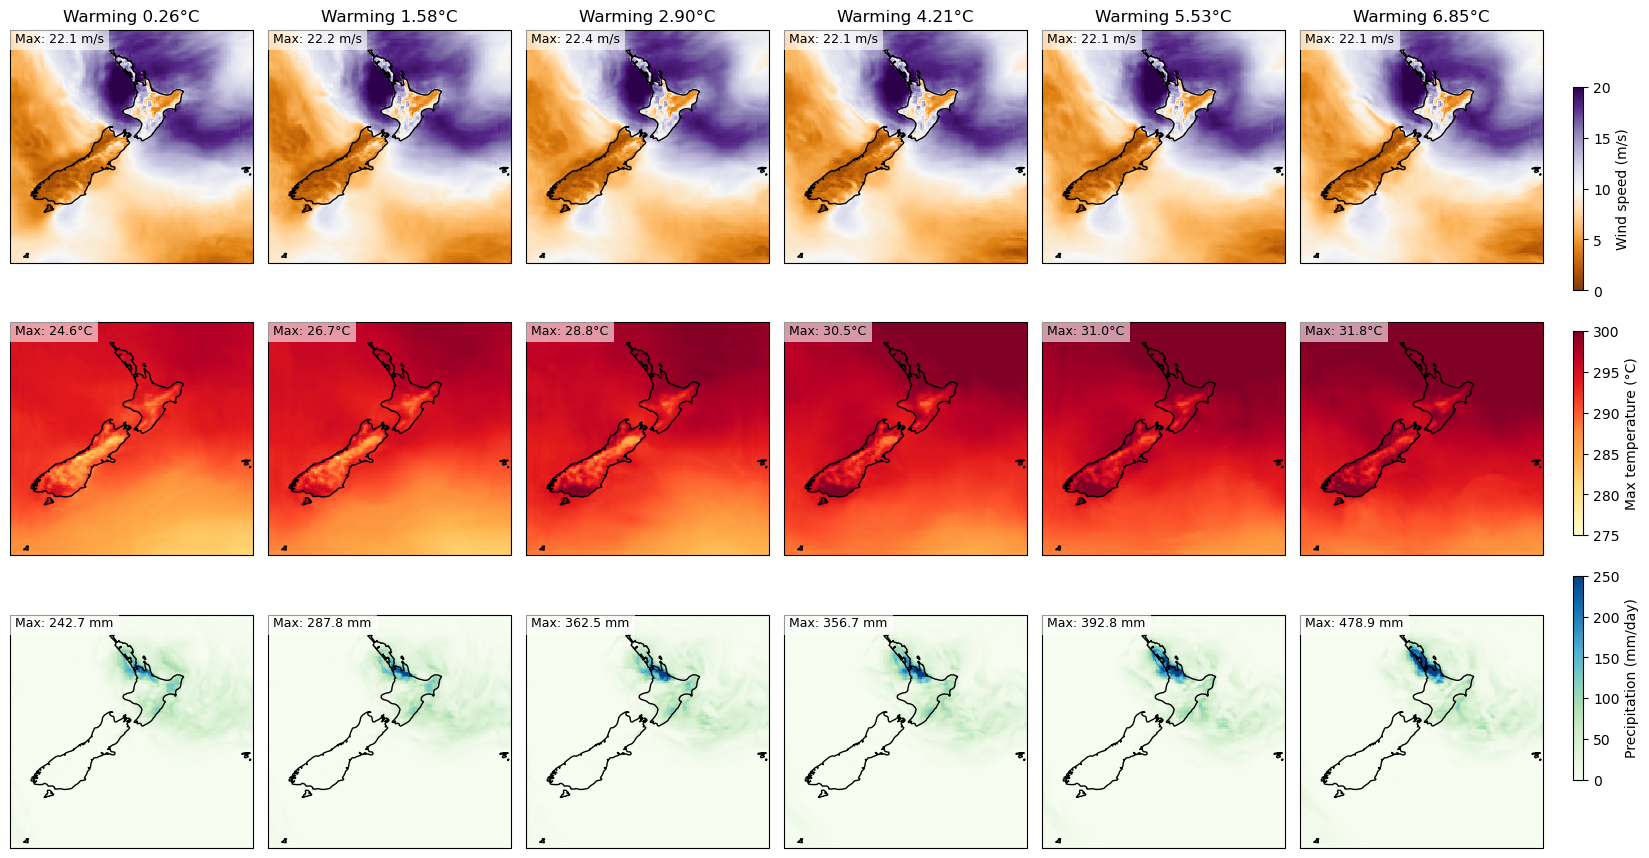

In [268]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# Select data for the date of interest
wind_data = outputs_wind.sel(time="2023-02-13").sfcWind
temp_data = outputs_temp.sel(time="2023-02-13").tasmax
rain_data = outputs.pr.sel(time="2023-02-13")

warming_levels = wind_data.warming.values  # Assuming warming is a coordinate

# Define color scales
wind_kwargs = dict(cmap="PuOr", vmin=0, vmax=20)
temp_kwargs = dict(cmap="YlOrRd", vmin=275, vmax=300)
rain_kwargs = dict(cmap="GnBu", vmin=0, vmax=250)

# Create figure and axes
fig, axes = plt.subplots(
    nrows=3, ncols=len(warming_levels),
    figsize=(18, 9),
    subplot_kw={"projection": ccrs.PlateCarree(central_longitude=171.77)}
)

# Row 1: Wind
for i, wl in enumerate(warming_levels):
    data_slice = wind_data.sel(warming=wl)
    im_wind = data_slice.plot(
        ax=axes[0, i], add_colorbar=False, transform=ccrs.PlateCarree(), **wind_kwargs
    )
    max_val = np.nanmax(data_slice.values)
    axes[0, i].text(0.02, 0.95, f"Max: {max_val:.1f} m/s",
                    transform=axes[0, i].transAxes, fontsize=9,
                    color="black", bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
    axes[0, i].coastlines()
    axes[0, i].set_title(f"Warming {zs[i]:.2f}°C")
    if i != 0:
        axes[0, i].set_ylabel("")

# Row 2: Temperature
for i, wl in enumerate(warming_levels):
    data_slice = temp_data.sel(warming=wl)
    im_temp = data_slice.plot(
        ax=axes[1, i], add_colorbar=False, transform=ccrs.PlateCarree(), **temp_kwargs
    )
    max_val = np.nanmax(data_slice.values) - 273.15  # Convert K to °C if needed
    axes[1, i].text(0.02, 0.95, f"Max: {max_val:.1f}°C",
                    transform=axes[1, i].transAxes, fontsize=9,
                    color="black", bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
    axes[1, i].set_title(' ')
    axes[1, i].coastlines()
    if i != 0:
        axes[1, i].set_ylabel("")

# Row 3: Rainfall
for i, wl in enumerate(warming_levels):
    data_slice = rain_data.sel(warming=wl)
    im_rain = data_slice.plot(
        ax=axes[2, i], add_colorbar=False, transform=ccrs.PlateCarree(), **rain_kwargs
    )
    max_val = np.nanmax(data_slice.values)
    axes[2, i].text(0.02, 0.95, f"Max: {max_val:.1f} mm",
                    transform=axes[2, i].transAxes, fontsize=9,
                    color="black", bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
    axes[2, i].coastlines()
    if i != 0:
        axes[2, i].set_ylabel("")
    axes[2, i].set_title(' ')

# Add one colorbar for each row (variable)
cbar_wind = fig.colorbar(im_wind, ax=axes[0, :], orientation="vertical", fraction=0.03, pad=-0.2)
cbar_wind.set_label("Wind speed (m/s)")

cbar_temp = fig.colorbar(im_temp, ax=axes[1, :], orientation="vertical", fraction=0.03, pad=-0.02)
cbar_temp.set_label("Max temperature (°C)")

cbar_rain = fig.colorbar(im_rain, ax=axes[2, :], orientation="vertical", fraction=0.03, pad=-0.02)
cbar_rain.set_label("Precipitation (mm/day)")

plt.tight_layout()
plt.show()


/tmp/ipykernel_254073/1560840208.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


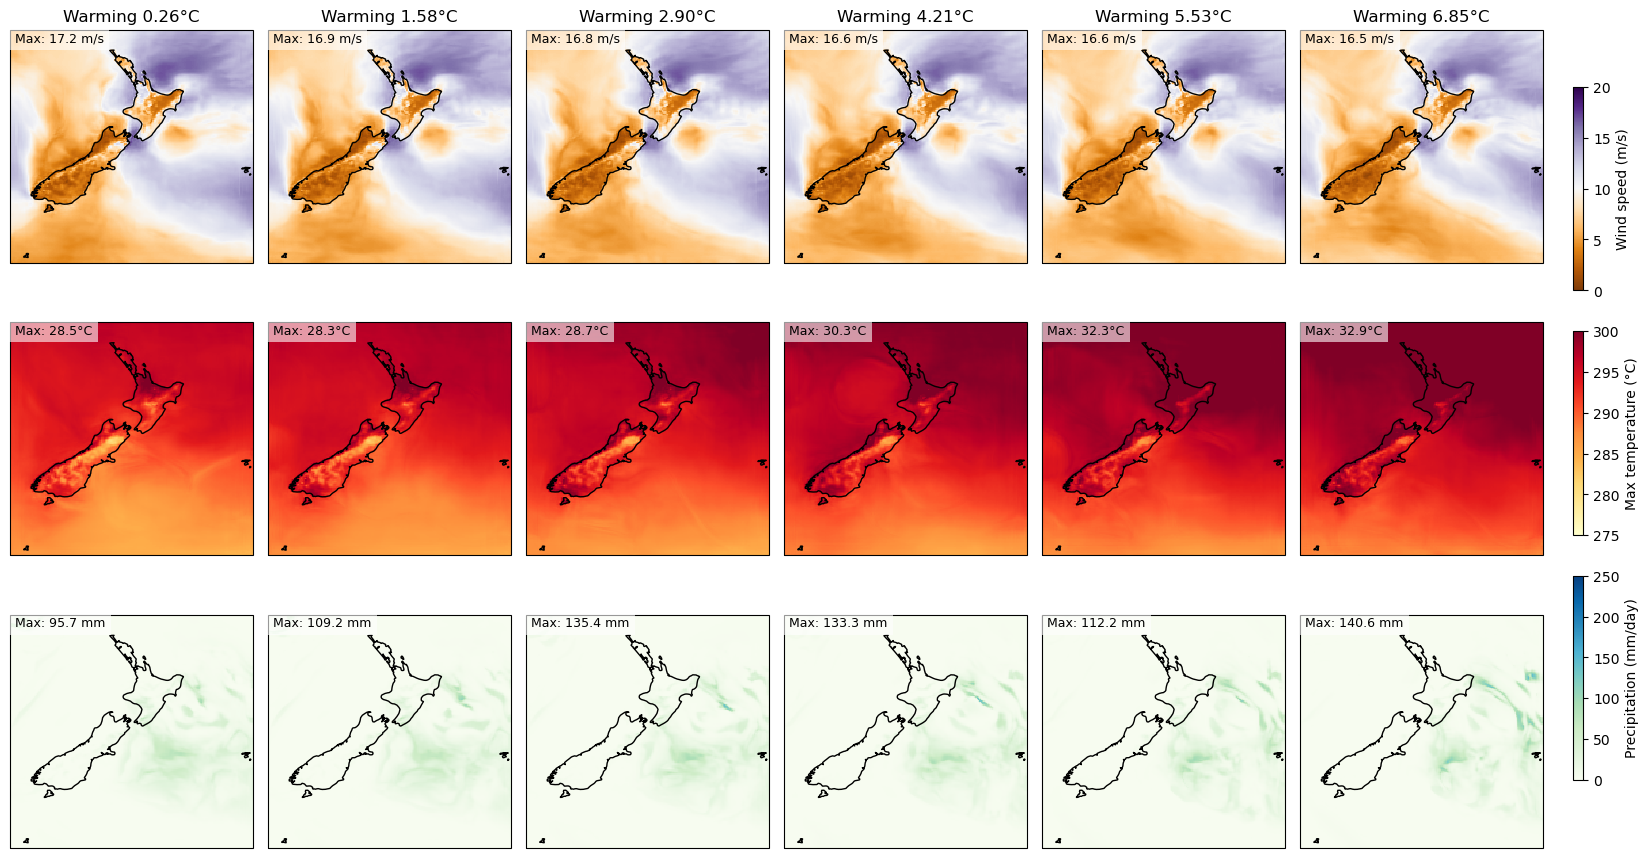

In [269]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# Select data for the date of interest
wind_data = outputs_wind.sel(time="2023-02-14").sfcWind
temp_data = outputs_temp.sel(time="2023-02-14").tasmax
rain_data = outputs.pr.sel(time="2023-02-14")

warming_levels = wind_data.warming.values  # Assuming warming is a coordinate

# Define color scales
wind_kwargs = dict(cmap="PuOr", vmin=0, vmax=20)
temp_kwargs = dict(cmap="YlOrRd", vmin=275, vmax=300)
rain_kwargs = dict(cmap="GnBu", vmin=0, vmax=250)

# Create figure and axes
fig, axes = plt.subplots(
    nrows=3, ncols=len(warming_levels),
    figsize=(18, 9),
    subplot_kw={"projection": ccrs.PlateCarree(central_longitude=171.77)}
)

# Row 1: Wind
for i, wl in enumerate(warming_levels):
    data_slice = wind_data.sel(warming=wl)
    im_wind = data_slice.plot(
        ax=axes[0, i], add_colorbar=False, transform=ccrs.PlateCarree(), **wind_kwargs
    )
    max_val = np.nanmax(data_slice.values)
    axes[0, i].text(0.02, 0.95, f"Max: {max_val:.1f} m/s",
                    transform=axes[0, i].transAxes, fontsize=9,
                    color="black", bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
    axes[0, i].coastlines()
    axes[0, i].set_title(f"Warming {zs[i]:.2f}°C")
    if i != 0:
        axes[0, i].set_ylabel("")

# Row 2: Temperature
for i, wl in enumerate(warming_levels):
    data_slice = temp_data.sel(warming=wl)
    im_temp = data_slice.plot(
        ax=axes[1, i], add_colorbar=False, transform=ccrs.PlateCarree(), **temp_kwargs
    )
    max_val = np.nanmax(data_slice.values) - 273.15  # Convert K to °C if needed
    axes[1, i].text(0.02, 0.95, f"Max: {max_val:.1f}°C",
                    transform=axes[1, i].transAxes, fontsize=9,
                    color="black", bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
    axes[1, i].set_title(' ')
    axes[1, i].coastlines()
    if i != 0:
        axes[1, i].set_ylabel("")

# Row 3: Rainfall
for i, wl in enumerate(warming_levels):
    data_slice = rain_data.sel(warming=wl)
    im_rain = data_slice.plot(
        ax=axes[2, i], add_colorbar=False, transform=ccrs.PlateCarree(), **rain_kwargs
    )
    max_val = np.nanmax(data_slice.values)
    axes[2, i].text(0.02, 0.95, f"Max: {max_val:.1f} mm",
                    transform=axes[2, i].transAxes, fontsize=9,
                    color="black", bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
    axes[2, i].coastlines()
    if i != 0:
        axes[2, i].set_ylabel("")
    axes[2, i].set_title(' ')

# Add one colorbar for each row (variable)
cbar_wind = fig.colorbar(im_wind, ax=axes[0, :], orientation="vertical", fraction=0.03, pad=-0.2)
cbar_wind.set_label("Wind speed (m/s)")

cbar_temp = fig.colorbar(im_temp, ax=axes[1, :], orientation="vertical", fraction=0.03, pad=-0.02)
cbar_temp.set_label("Max temperature (°C)")

cbar_rain = fig.colorbar(im_rain, ax=axes[2, :], orientation="vertical", fraction=0.03, pad=-0.02)
cbar_rain.set_label("Precipitation (mm/day)")

plt.tight_layout()
plt.show()


/tmp/ipykernel_254073/3228311284.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


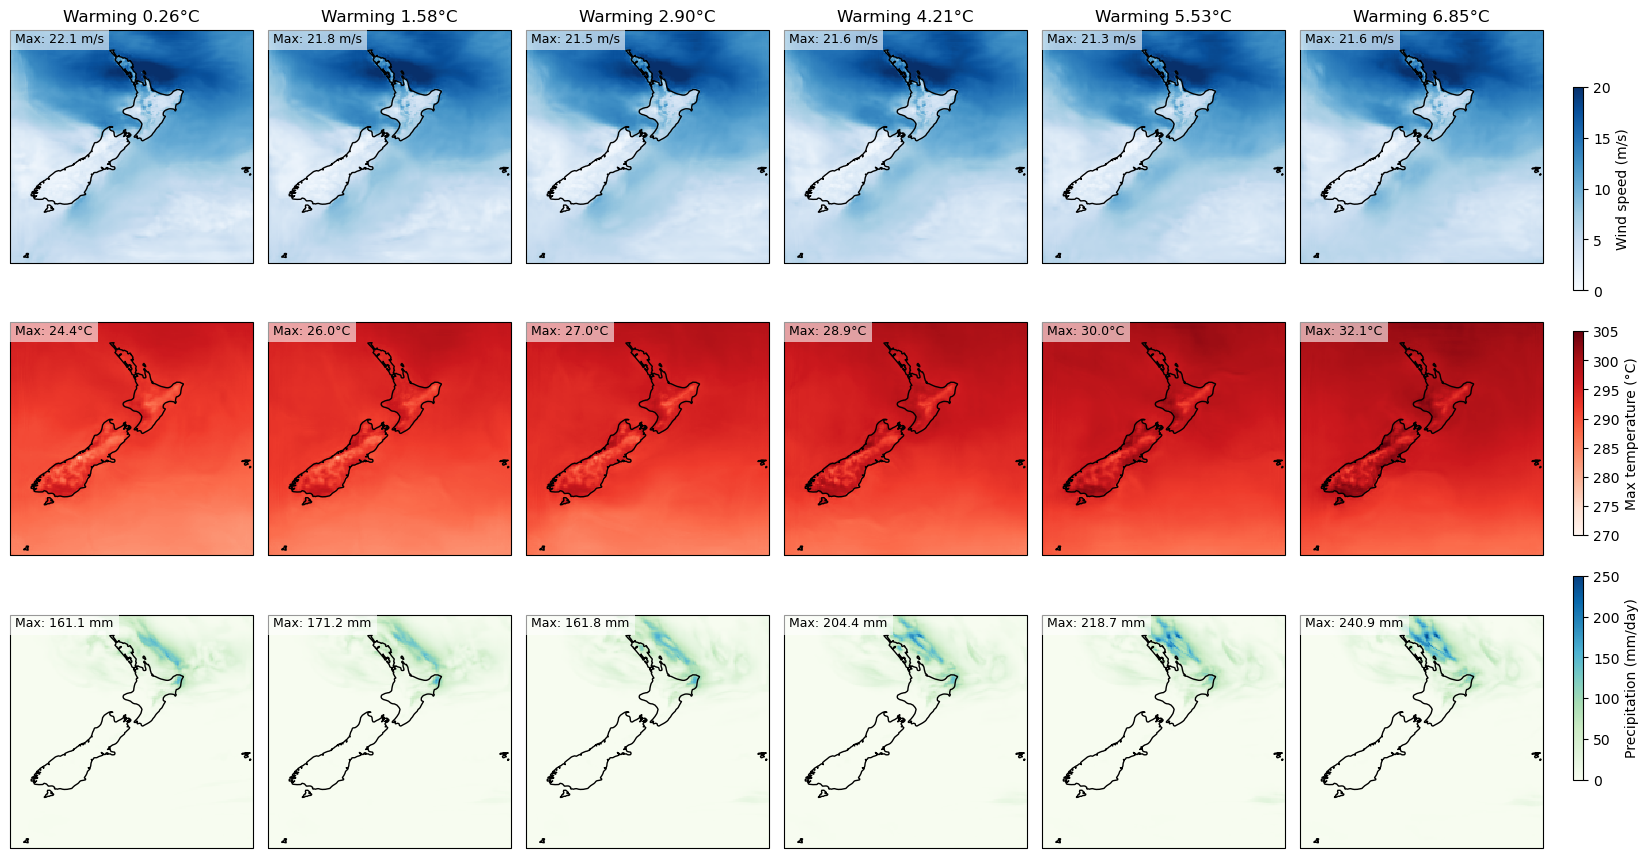

In [257]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# Select data for the date of interest
wind_data = outputs_wind.sel(time="2023-02-12").sfcWind
temp_data = outputs_temp.sel(time="2023-02-12").tasmax
rain_data = outputs.pr.sel(time="2023-02-12")

warming_levels = wind_data.warming.values  # Assuming warming is a coordinate

# Define color scales
wind_kwargs = dict(cmap="Blues", vmin=0, vmax=20)
temp_kwargs = dict(cmap="Reds", vmin=270, vmax=305)
rain_kwargs = dict(cmap="GnBu", vmin=0, vmax=250)

# Create figure and axes
fig, axes = plt.subplots(
    nrows=3, ncols=len(warming_levels),
    figsize=(18, 9),
    subplot_kw={"projection": ccrs.PlateCarree(central_longitude=171.77)}
)

# Row 1: Wind
for i, wl in enumerate(warming_levels):
    data_slice = wind_data.sel(warming=wl)
    im_wind = data_slice.plot(
        ax=axes[0, i], add_colorbar=False, transform=ccrs.PlateCarree(), **wind_kwargs
    )
    max_val = np.nanmax(data_slice.values)
    axes[0, i].text(0.02, 0.95, f"Max: {max_val:.1f} m/s",
                    transform=axes[0, i].transAxes, fontsize=9,
                    color="black", bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
    axes[0, i].coastlines()
    axes[0, i].set_title(f"Warming {zs[i]:.2f}°C")
    if i != 0:
        axes[0, i].set_ylabel("")

# Row 2: Temperature
for i, wl in enumerate(warming_levels):
    data_slice = temp_data.sel(warming=wl)
    im_temp = data_slice.plot(
        ax=axes[1, i], add_colorbar=False, transform=ccrs.PlateCarree(), **temp_kwargs
    )
    max_val = np.nanmax(data_slice.values) - 273.15  # Convert K to °C if needed
    axes[1, i].text(0.02, 0.95, f"Max: {max_val:.1f}°C",
                    transform=axes[1, i].transAxes, fontsize=9,
                    color="black", bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
    axes[1, i].set_title(' ')
    axes[1, i].coastlines()
    if i != 0:
        axes[1, i].set_ylabel("")

# Row 3: Rainfall
for i, wl in enumerate(warming_levels):
    data_slice = rain_data.sel(warming=wl)
    im_rain = data_slice.plot(
        ax=axes[2, i], add_colorbar=False, transform=ccrs.PlateCarree(), **rain_kwargs
    )
    max_val = np.nanmax(data_slice.values)
    axes[2, i].text(0.02, 0.95, f"Max: {max_val:.1f} mm",
                    transform=axes[2, i].transAxes, fontsize=9,
                    color="black", bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
    axes[2, i].coastlines()
    if i != 0:
        axes[2, i].set_ylabel("")
    axes[2, i].set_title(' ')

# Add one colorbar for each row (variable)
cbar_wind = fig.colorbar(im_wind, ax=axes[0, :], orientation="vertical", fraction=0.03, pad=-0.2)
cbar_wind.set_label("Wind speed (m/s)")

cbar_temp = fig.colorbar(im_temp, ax=axes[1, :], orientation="vertical", fraction=0.03, pad=-0.02)
cbar_temp.set_label("Max temperature (°C)")

cbar_rain = fig.colorbar(im_rain, ax=axes[2, :], orientation="vertical", fraction=0.03, pad=-0.02)
cbar_rain.set_label("Precipitation (mm/day)")

plt.tight_layout()
plt.show()


/tmp/ipykernel_254073/4088820707.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


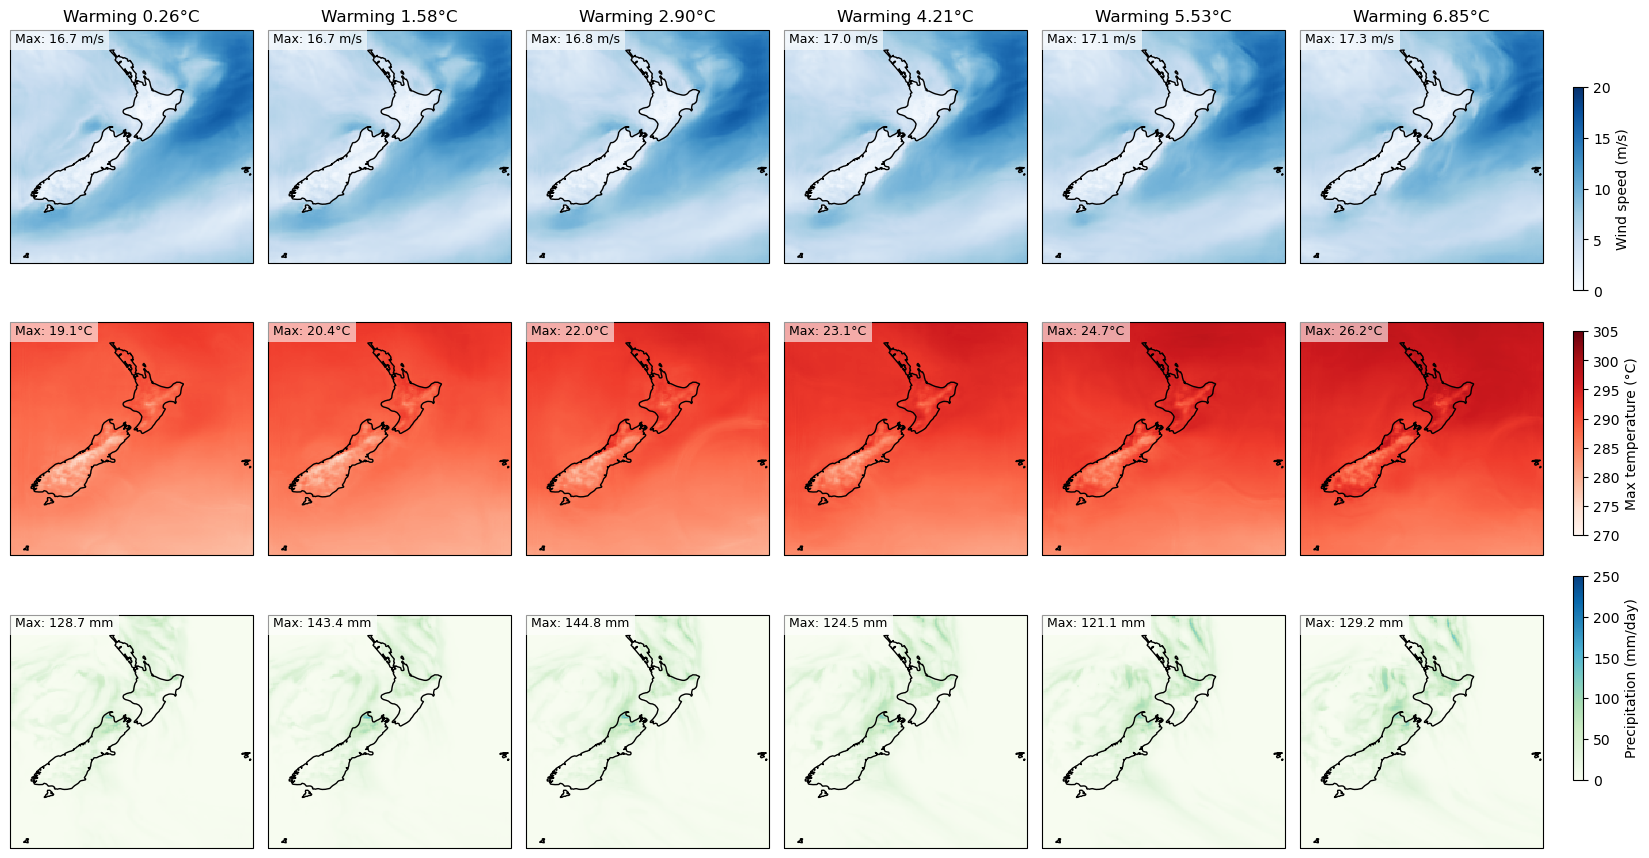

In [266]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# Select data for the date of interest
wind_data = outputs_wind.sel(time="2024-06-24").sfcWind
temp_data = outputs_temp.sel(time="2024-06-24").tasmax
rain_data = outputs.pr.sel(time="2023--02")

warming_levels = wind_data.warming.values  # Assuming warming is a coordinate

# Define color scales
wind_kwargs = dict(cmap="Blues", vmin=0, vmax=20)
temp_kwargs = dict(cmap="Reds", vmin=270, vmax=305)
rain_kwargs = dict(cmap="GnBu", vmin=0, vmax=250)

# Create figure and axes
fig, axes = plt.subplots(
    nrows=3, ncols=len(warming_levels),
    figsize=(18, 9),
    subplot_kw={"projection": ccrs.PlateCarree(central_longitude=171.77)}
)

# Row 1: Wind
for i, wl in enumerate(warming_levels):
    data_slice = wind_data.sel(warming=wl)
    im_wind = data_slice.plot(
        ax=axes[0, i], add_colorbar=False, transform=ccrs.PlateCarree(), **wind_kwargs
    )
    max_val = np.nanmax(data_slice.values)
    axes[0, i].text(0.02, 0.95, f"Max: {max_val:.1f} m/s",
                    transform=axes[0, i].transAxes, fontsize=9,
                    color="black", bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
    axes[0, i].coastlines()
    axes[0, i].set_title(f"Warming {zs[i]:.2f}°C")
    if i != 0:
        axes[0, i].set_ylabel("")

# Row 2: Temperature
for i, wl in enumerate(warming_levels):
    data_slice = temp_data.sel(warming=wl)
    im_temp = data_slice.plot(
        ax=axes[1, i], add_colorbar=False, transform=ccrs.PlateCarree(), **temp_kwargs
    )
    max_val = np.nanmax(data_slice.values) - 273.15  # Convert K to °C if needed
    axes[1, i].text(0.02, 0.95, f"Max: {max_val:.1f}°C",
                    transform=axes[1, i].transAxes, fontsize=9,
                    color="black", bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
    axes[1, i].set_title(' ')
    axes[1, i].coastlines()
    if i != 0:
        axes[1, i].set_ylabel("")

# Row 3: Rainfall
for i, wl in enumerate(warming_levels):
    data_slice = rain_data.sel(warming=wl)
    im_rain = data_slice.plot(
        ax=axes[2, i], add_colorbar=False, transform=ccrs.PlateCarree(), **rain_kwargs
    )
    max_val = np.nanmax(data_slice.values)
    axes[2, i].text(0.02, 0.95, f"Max: {max_val:.1f} mm",
                    transform=axes[2, i].transAxes, fontsize=9,
                    color="black", bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
    axes[2, i].coastlines()
    if i != 0:
        axes[2, i].set_ylabel("")
    axes[2, i].set_title(' ')

# Add one colorbar for each row (variable)
cbar_wind = fig.colorbar(im_wind, ax=axes[0, :], orientation="vertical", fraction=0.03, pad=-0.2)
cbar_wind.set_label("Wind speed (m/s)")

cbar_temp = fig.colorbar(im_temp, ax=axes[1, :], orientation="vertical", fraction=0.03, pad=-0.02)
cbar_temp.set_label("Max temperature (°C)")

cbar_rain = fig.colorbar(im_rain, ax=axes[2, :], orientation="vertical", fraction=0.03, pad=-0.02)
cbar_rain.set_label("Precipitation (mm/day)")

plt.tight_layout()
plt.show()


In [258]:
outputs.pr

<xarray.DataArray 'pr' (warming: 6, time: 731, lat: 172, lon: 179)>
array([[[[4.13879752e-01, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 7.27844238e-03],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [6.25111222e-01, 5.95179319e-01, 6.39712572e-01, ...,
          1.35948420e+00, 1.27550721e+00, 1.18111634e+00],
         [5.72774172e-01, 6.90968037e-01, 6.93929911e-01, ...,
          1.35932493e+00, 1.21124744e+00, 1.19040680e+00],
         [1.13582993e+00, 7.69415498e-01, 7.42514849e-01, ...,
          1.19502831e+00, 9.76800799e-01, 7.62747169e-01]],

        [[6.95533156e-01, 5.49017072e-01, 4.47734833e-01, ...,
          6.01831555e-01, 7.30727911e-01, 6.90469503e-01],
         [5.26852727e-01, 5.12085676e-01, 4.79101539e-01, ...,
          6.07590318e-01, 7.25820661e-01, 7.06466317e-01],
         [5.11838794e-01, 4.49121118e-01, 4.45035219e-01, ...,
          6.16949320e-01, 7.52691150e-01, 7.32839823e-01],
...
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          8.61312747e-01, 7.72615910e-01, 7.39787459e-01],
         [0.00000000e+00, 0.00000000e+00, 1.33631229e-02, ...,
          8.58549476e-01, 6.79480433e-01, 1.08739185e+00],
         [1.29873753e-02, 0.00000000e+00, 0.00000000e+00, ...,
          5.90868592e-01, 1.26096892e+00, 1.00855565e+00]],

        [[1.25226045e+00, 1.15308142e+00, 1.04563546e+00, ...,
          3.78451467e-01, 3.82163286e-01, 3.70275855e-01],
         [8.87804151e-01, 8.28278422e-01, 7.22425699e-01, ...,
          4.03102398e-01, 3.84059548e-01, 3.64997625e-01],
         [7.43027449e-01, 6.02203727e-01, 6.09488487e-01, ...,
          3.95081997e-01, 3.90317559e-01, 3.61390591e-01],
         ...,
         [8.07534456e-02, 7.67955780e-02, 6.26643896e-02, ...,
          7.63143778e-01, 1.02244163e+00, 1.34675074e+00],
         [7.37861395e-02, 9.01601315e-02, 6.93106651e-02, ...,
          2.33838654e+00, 2.26765990e+00, 2.15512514e+00],
         [1.11692667e-01, 3.14432383e-02, 4.35907841e-02, ...,
          2.54539156e+00, 2.08694434e+00, 1.24074292e+00]]]])
Coordinates:
  * lon      (lon) float32 164.9 165.0 165.1 165.2 ... 183.6 183.7 183.9 184.0
  * lat      (lat) float32 -51.21 -51.11 -51.0 -50.89 ... -33.07 -32.97 -32.86
    GCM      <U10 'ACCESS-CM2'
  * time     (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2024-12-31
Dimensions without coordinates: warming

/tmp/ipykernel_254073/3430280442.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


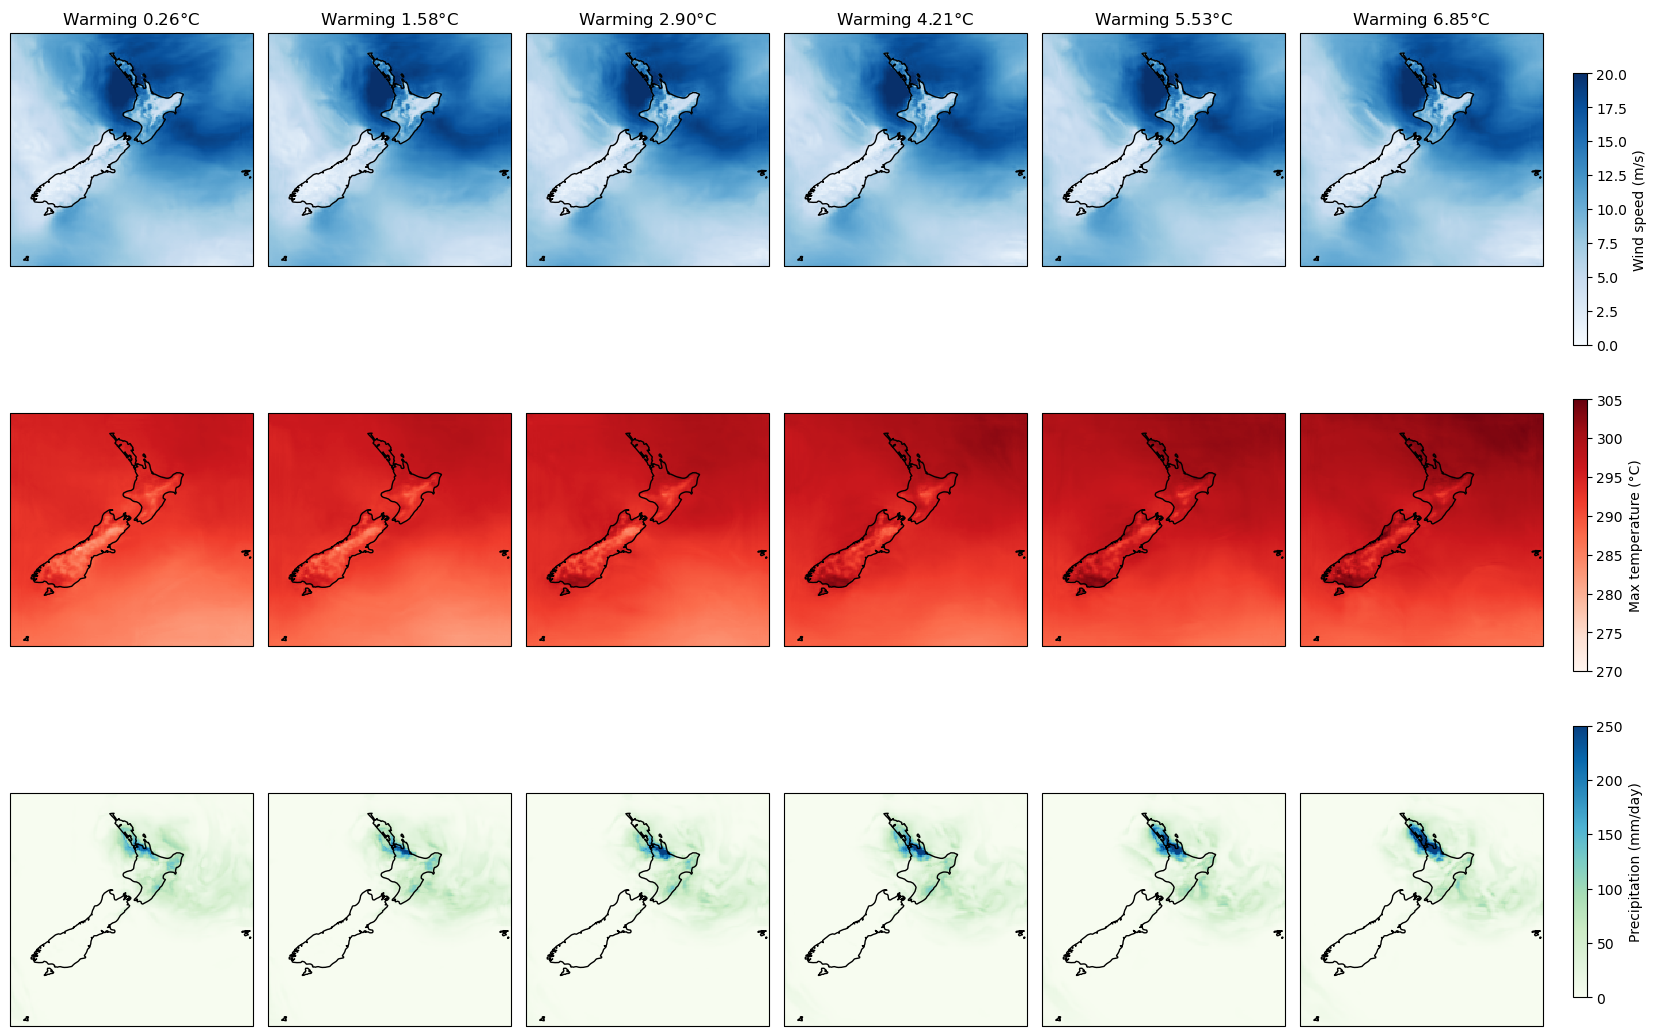

In [251]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Select data for the date of interest
wind_data = outputs_wind.sel(time="2023-02-13").sfcWind
temp_data = outputs_temp.sel(time="2023-02-13").tasmax
rain_data = outputs.pr.sel(time="2023-02-13")

warming_levels = wind_data.warming.values  # Assuming warming is a coordinate

# Define color scales
wind_kwargs = dict(cmap="Blues", vmin=0, vmax=20)
temp_kwargs = dict(cmap="Reds", vmin=270, vmax=305)
rain_kwargs = dict(cmap="GnBu", vmin=0, vmax=250)

# Create figure and axes
fig, axes = plt.subplots(
    nrows=3, ncols=len(warming_levels),
    figsize=(18, 12),
    subplot_kw={"projection": ccrs.PlateCarree(central_longitude =171.77)}
)

# Row 1: Wind
for i, wl in enumerate(warming_levels):
    im_wind = wind_data.sel(warming=wl).plot(
        ax=axes[0, i], add_colorbar=False, transform = ccrs.PlateCarree(), **wind_kwargs
    )
    axes[0, i].coastlines()
    axes[0, i].set_title(f"Warming {'%.2f' % zs[i]}$\degree$C")
    if i != 0:
        axes[0, i].set_ylabel("")

# Row 2: Temperature
for i, wl in enumerate(warming_levels):
    im_temp = temp_data.sel(warming=wl).plot(
        ax=axes[1, i], add_colorbar=False, transform = ccrs.PlateCarree(), **temp_kwargs
    )
    axes[1, i].set_title(' ')
    axes[1, i].coastlines()
    if i != 0:
        axes[1, i].set_ylabel("")

# Row 3: Rainfall
for i, wl in enumerate(warming_levels):
    im_rain = rain_data.sel(warming=wl).plot(
        ax=axes[2, i], add_colorbar=False, transform = ccrs.PlateCarree(), **rain_kwargs
    )
    axes[2, i].coastlines()
    if i != 0:
        axes[2, i].set_ylabel("")
        axes[2, i].set_title(' ')
    axes[2, i].set_title(' ')

# Add one colorbar for each row (variable)
cbar_wind = fig.colorbar(im_wind, ax=axes[0, :], orientation="vertical", fraction=0.03, pad=-0.2)
cbar_wind.set_label("Wind speed (m/s)")

cbar_temp = fig.colorbar(im_temp, ax=axes[1, :], orientation="vertical", fraction=0.03, pad=-0.02)
cbar_temp.set_label("Max temperature (°C)")

cbar_rain = fig.colorbar(im_rain, ax=axes[2, :], orientation="vertical", fraction=0.03, pad=-0.02)
cbar_rain.set_label("Precipitation (mm/day)")

plt.tight_layout()
plt.show()


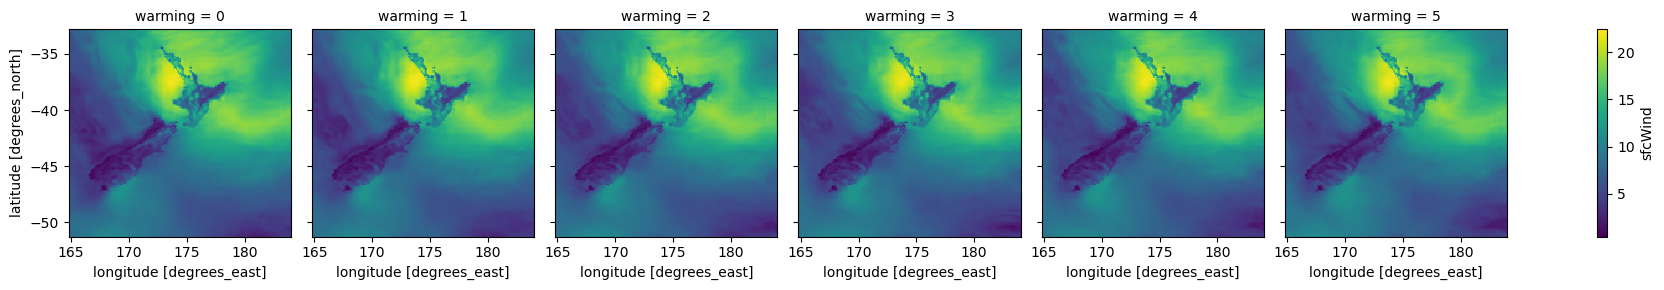

In [221]:
outputs_wind.sel(time ="2023-02-13").sfcWind.plot(col="warming")
outputs_temp.sel(time ="2023-02-13").tasmax.plot(col="warming")
outputs.pr.sel(time = "2023-02-13").plot(col ="warming", vmax =250)

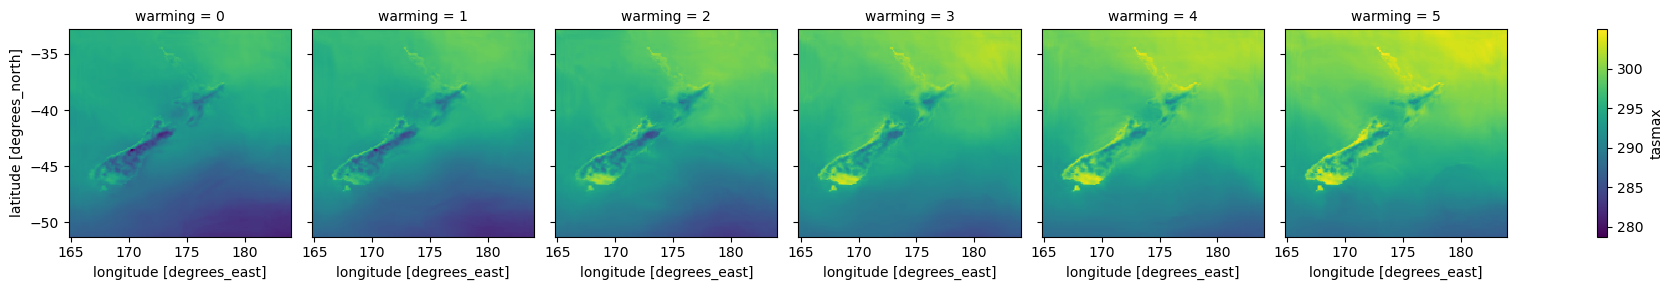

In [226]:
outputs_temp.sel(time ="2023-02-13").tasmax.plot(col="warming")
outputs.pr.sel(time = "2023-02-13").plot(col ="warming", vmax =250)

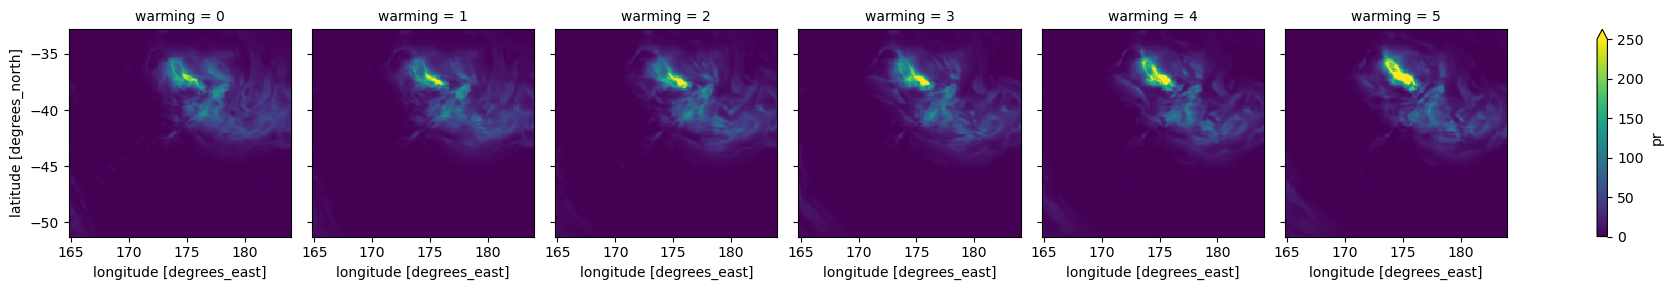

In [227]:
outputs.pr.sel(time = "2023-02-13").plot(col ="warming", vmax =250)

In [130]:
outputs = xr.concat(outputs, dim = "warming")

In [167]:
percentage  = 100 * (outputs.pr.sel(time = "2023-02-13").max(["lat","lon"]) - outputs.pr.sel(time = "2023-02-13").max(["lat","lon"]).min())/outputs.pr.sel(time = "2023-02-13").max(["lat","lon"]).min()
from scipy.stats import linregress
f = linregress(zs, percentage)

In [170]:
percentage

<xarray.DataArray 'pr' (warming: 6)>
array([ 0.        , 18.59072413, 49.34735895, 46.97895774, 61.84093408,
       97.3420293 ])
Coordinates:
    GCM      <U10 'ACCESS-CM2'
    time     datetime64[ns] 2023-02-13
Dimensions without coordinates: warming

In [171]:
from scipy.stats import linregress
f = linregress(zs, percentage)

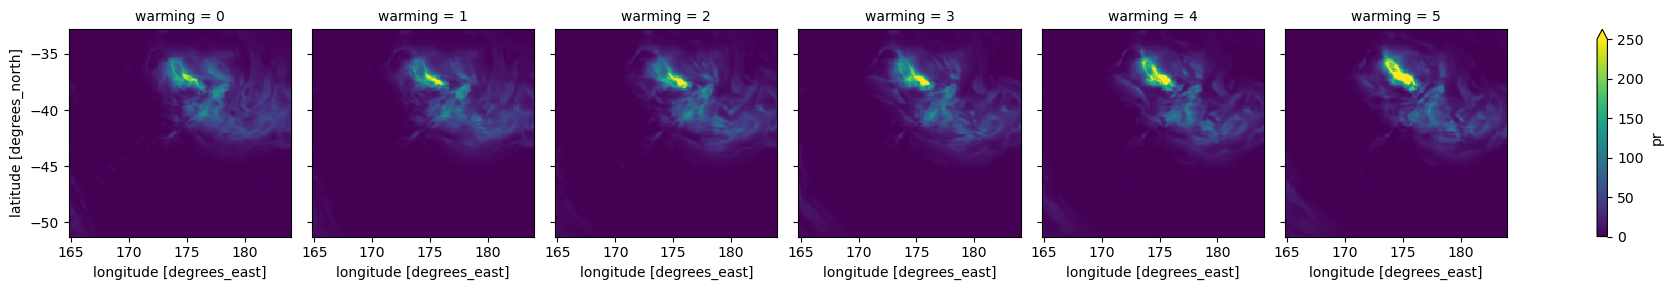

In [205]:
outputs.pr.sel(time = "2023-02-13").plot(col ="warming", vmax =250)

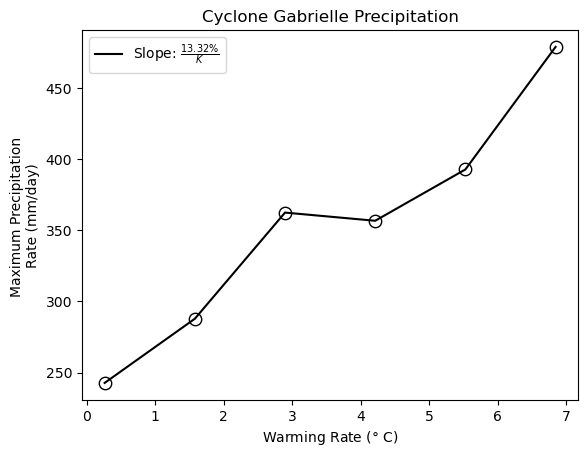

In [188]:
fig, ax = plt.subplots()
ax.scatter(zs, outputs.pr.sel(time = "2023-02-13").max(["lat","lon"]).values, s= 80, marker ='o', fc ='white', ec ='k') 
ax.plot(zs, outputs.pr.sel(time = "2023-02-13").max(["lat","lon"]).values, color ='k', label = r'Slope: $\frac{13.32 \%}{K}$') 
ax.set_xlabel('Warming Rate ($\degree$ C)')
ax.set_ylabel('Maximum Precipitation \nRate (mm/day)')
ax.set_title('Cyclone Gabrielle Precipitation')
ax.legend()

In [216]:
# fig, ax = plt.subplots()
# ax.scatter(zs, outputs.pr.sel(time = "2023-01-26").max(["lat","lon"]).values, s= 80, marker ='o', fc ='white', ec ='k') 
# ax.plot(zs, outputs.pr.sel(time = "2023-01-26").max(["lat","lon"]).values, color ='k', label = r'Slope: $\frac{13.32 \%}{K}$') 
# ax.set_xlabel('Warming Rate ($\degree$ C)')
# ax.set_ylabel('Maximum Precipitation \nRate (mm/day)')
# #ax.set_title('Cyclone Gabrielle Precipitation')
# ax.legend()

In [189]:
percentage2  = 100 * (outputs.pr.max(["time"]).mean(["lat","lon"]) - outputs.pr.max(["time"]).mean(["lat","lon"]).min())/outputs.pr.max(["time"]).mean(["lat","lon"]).min()
from scipy.stats import linregress
f = linregress(zs, percentage2)

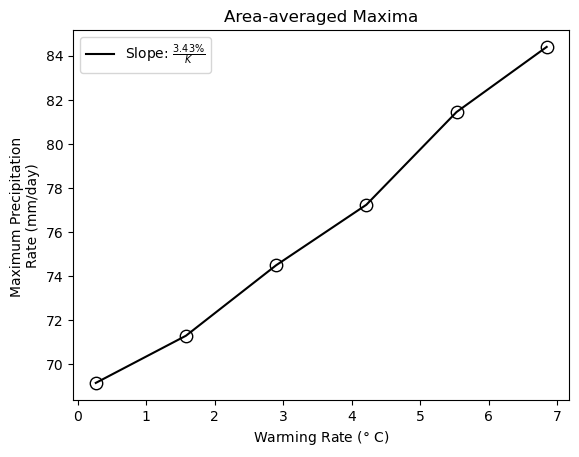

In [192]:
fig, ax = plt.subplots()
label = rf'Slope: $\frac{{{f.slope:.2f}\%}}{{K}}$'
ax.scatter(zs, outputs.pr.max(["time"]).mean(["lat","lon"]).values, s= 80, marker ='o', fc ='white', ec ='k') 
ax.plot(zs, outputs.pr.max(["time"]).mean(["lat","lon"]).values, color ='k', label = label) 
ax.set_xlabel('Warming Rate ($\degree$ C)')
ax.set_ylabel('Maximum Precipitation \nRate (mm/day)')
ax.set_title('Area-averaged Maxima')
ax.legend()

In [185]:
outputs.pr.sel(time = "2023-02-13")

<xarray.DataArray 'pr' (warming: 6, lat: 172, lon: 179)>
array([[[1.20630922e+01, 8.55631447e+00, 6.41970253e+00, ...,
         9.61852074e-03, 9.24754143e-02, 1.42044663e-01],
        [8.91094494e+00, 8.04927063e+00, 6.75999165e+00, ...,
         1.00339651e-02, 6.69384003e-03, 4.24886942e-02],
        [8.20346355e+00, 6.75591803e+00, 6.33259058e+00, ...,
         1.94456577e-02, 2.54908800e-02, 3.31555605e-02],
        ...,
        [7.15477467e-02, 4.47953939e-02, 3.94892693e-02, ...,
         1.22418475e+00, 1.15976834e+00, 1.11344790e+00],
        [2.38723755e-02, 2.54096985e-02, 5.69288731e-02, ...,
         9.56203699e-01, 1.17025661e+00, 1.37410140e+00],
        [2.59518504e-01, 7.23237991e-02, 6.86818361e-02, ...,
         1.32734036e+00, 1.60114360e+00, 1.39548445e+00]],

       [[1.03196821e+01, 8.01709843e+00, 6.65308809e+00, ...,
         2.05244899e-01, 2.21879482e-01, 2.66579628e-01],
        [8.31140327e+00, 7.79099560e+00, 7.53919220e+00, ...,
         2.71088243e-01, 2.57177711e-01, 2.65431046e-01],
        [8.00860023e+00, 7.98146534e+00, 8.37550354e+00, ...,
         3.30394030e-01, 2.86211252e-01, 2.73404598e-01],
...
        [1.26218915e-01, 1.34959340e-01, 1.15725875e-01, ...,
         1.80143809e+00, 1.96426916e+00, 2.16653895e+00],
        [1.39289737e-01, 1.36471868e-01, 1.12909317e-01, ...,
         2.06949568e+00, 2.02098298e+00, 2.35826373e+00],
        [2.92989492e-01, 1.52705789e-01, 1.36115074e-01, ...,
         1.98806214e+00, 1.88915896e+00, 2.13092852e+00]],

       [[8.31973171e+00, 7.27150059e+00, 6.83422709e+00, ...,
         2.22995996e-01, 2.58183837e-01, 2.60293365e-01],
        [7.55875301e+00, 8.13489056e+00, 7.59529400e+00, ...,
         2.26210475e-01, 2.19645023e-01, 1.86297059e-01],
        [7.36662769e+00, 7.77517700e+00, 7.82830429e+00, ...,
         2.23555088e-01, 2.18421340e-01, 1.65656209e-01],
        ...,
        [1.86672688e-01, 1.84298873e-01, 1.85499191e-01, ...,
         1.88968682e+00, 1.97004890e+00, 2.12024617e+00],
        [1.63074613e-01, 1.46826386e-01, 1.62171245e-01, ...,
         1.91161060e+00, 2.01214337e+00, 2.68100905e+00],
        [3.46595168e-01, 1.53093338e-01, 1.31529927e-01, ...,
         2.07803059e+00, 2.16236210e+00, 2.20558381e+00]]])
Coordinates:
  * lon      (lon) float32 164.9 165.0 165.1 165.2 ... 183.6 183.7 183.9 184.0
  * lat      (lat) float32 -51.21 -51.11 -51.0 -50.89 ... -33.07 -32.97 -32.86
    GCM      <U10 'ACCESS-CM2'
    time     datetime64[ns] 2023-02-13
Dimensions without coordinates: warming

In [102]:
input_file2 = r'/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/GCM_emulator/ERA5_remapped_con_v3_lat_lon.nc'
framework = 'perfect'



#config_file = model_dir + ml_model_name + '/config_info.json'
# with open(config_file) as f:
#     config = json.load(f)

output_means = xr.open_dataset(config["means_output"])
output_stds = xr.open_dataset(config["stds_output"])
# LOAD ML MODEL
print('LOAD ML MODEL\n')

# PREP INPUT
print('\nPREP INPUT')
processed_GCM_data, mean_data, variance_data, vegt, orog, he, time_of_year = prepare_ML_inputs(input_file2, config,
                                                                                               framework, method = method)
    
with ProgressBar():
    mean_data = mean_data.load()
    variance_data = variance_data.load()
    processed_GCM_data = processed_GCM_data.load()
    time_of_year = time_of_year.load()
    print(mean_data, time_of_year)
    print('PREP OUTPUT')
output_shape = initialize_output_ds(processed_GCM_data, config)
output_shape = output_shape.rename({"pr": variable})
print('APPLY ML MODEL')
ts = slice("2020","2024")
output_normal = predict_parallel_resid_corrector_v5varname(generator, unet_model,
                                                    processed_GCM_data.transpose('time', 'lat', 'lon',
                                                                                 'channel').sel(time = ts).values, \
                                                    output_shape.sel(time = ts), 64, orog, output_means, output_stds, time_of_year.sel(time = ts), \
                                                    mean_data.sel(time = ts).transpose('time', 'channel'),
                                                    variance_data.sel(time = ts).transpose('time', 'channel'), gan=GAN_flag, \
                                                    min_value=min_value, varname=variable)

LOAD ML MODEL


PREP INPUT
[########################################] | 100% Completed | 608.08 ms
	- processing GCM input data
		- normalizing by mean and standard deviation
		- concatenating variables to channel dimension
	- processing mean, variance, and time data
	- processing static fields
	- calculating time of year array
<xarray.DataArray 'q_500' (channel: 8, time: 1917)>
array([[ 0.0728431 , -0.2631139 ,  0.02621691, ...,  0.55133903,
         0.15662372,  0.51374666],
       [-0.24688246, -0.41179617, -0.78732872, ...,  0.58962169,
         0.57150923,  0.59330503],
       [-0.42114816, -0.64515442, -0.48592287, ...,  0.02523871,
         0.04116845, -0.13520547],
       ...,
       [ 0.29345572,  0.71665609,  1.06025077, ..., -0.45154939,
         0.22956764,  0.45707956],
       [ 0.82482442,  0.51840396,  0.34242271, ...,  0.29587093,
         0.21022262,  0.56879884],
       [ 1.29976687,  0.91874212,  0.57621322, ...,  0.24355668,
         0.1377466 ,  0.33942379]])
Coord

Predicting: 100%|██████████| 28/28 [00:31<00:00,  1.13s/batch]


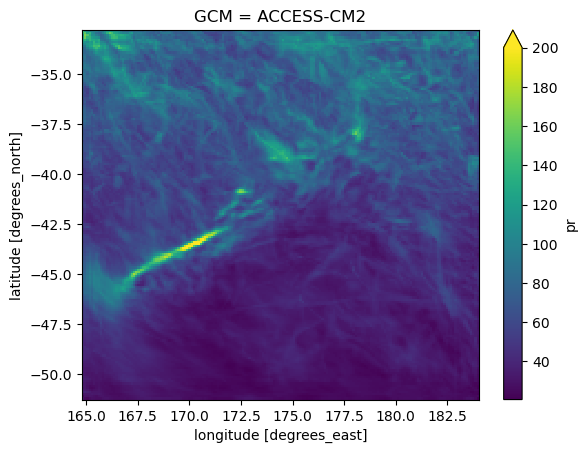

In [119]:
output_normal.groupby('time.year').max().mean("year").pr.plot(vmax =200)

In [122]:
z = output_normal.groupby('time.year').max().mean("year").pr  - output2.groupby('time.year').max().mean("year").pr

In [123]:
z.mean()

<xarray.DataArray 'pr' ()>
array(-6.96181266)
Coordinates:
    GCM      <U10 'ACCESS-CM2'

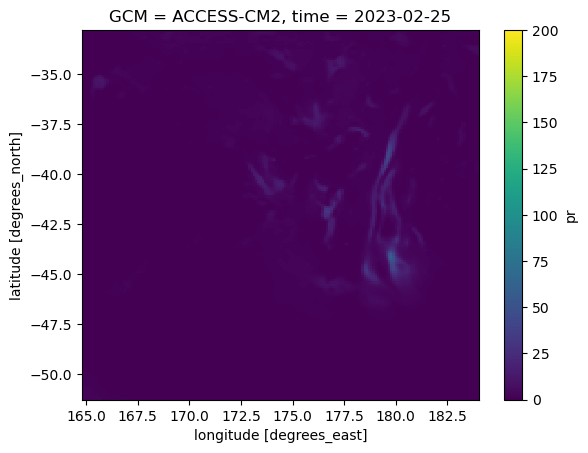

In [113]:
output2.sel(time = "2023-02-25").pr.plot(vmax =200)

In [22]:
preds = []
exps = []
for file in files:
    
    # lets first convert the files
    def convert_file(path):
        df2 = xr.open_dataset(path).rename({"lev":"plev"})
        df2 = df2.sel(time = slice("2095","2100"))
        try:
            df2.to_netcdf(path.replace(".nc","_updated.nc"))
        except:
            print("file_exists")
    exp = file.split('.')[0].split('_')[-1]
    convert_file(file)
    # now change the file name
    input_file2 = file.replace(".nc","_updated.nc")
    # update file ane
    
    config_file = model_dir + ml_model_name + '/config_info.json'
    with open(config_file) as f:
        config = json.load(f)

    output_means = xr.open_dataset(config["means_output"])
    output_stds = xr.open_dataset(config["stds_output"])
    # LOAD ML MODEL
    print('LOAD ML MODEL\n')

    # PREP INPUT
    print('\nPREP INPUT')
    processed_GCM_data, mean_data, variance_data, vegt, orog, he, time_of_year = prepare_ML_inputs(input_file2, config,
                                                                                                   framework, method = method)
    
    with ProgressBar():
        mean_data = mean_data.load()
        variance_data = variance_data.load()
        processed_GCM_data = processed_GCM_data.load()
        time_of_year = time_of_year.load()
        print(mean_data, time_of_year)
    print('PREP OUTPUT')
    output_shape = initialize_output_ds(processed_GCM_data, config)
    output_shape = output_shape.rename({"pr": variable})
# APPLY MODEL
    print('APPLY ML MODEL')
    ts = slice("2095","2100")
    output2 = predict_parallel_resid_corrector_v5varname(generator, unet_model,
                                                        processed_GCM_data.transpose('time', 'lat', 'lon',
                                                                                     'channel').sel(time = ts).values, \
                                                        output_shape.sel(time = ts), 64, orog, output_means, output_stds, time_of_year.sel(time = ts), \
                                                        mean_data.sel(time = ts).transpose('time', 'channel'),
                                                        variance_data.sel(time = ts).transpose('time', 'channel'), gan=GAN_flag, \
                                                        min_value=min_value, varname=variable)
    output2.to_netcdf(input_file2.replace(".nc", "_downscaled.nc"))
    preds.append(output2)
    exps.append(exp)

LOAD ML MODEL


PREP INPUT
[########################################] | 100% Completed | 1.41 sms
	- processing GCM input data
		- unstacking pressure levels
		- normalizing by mean and standard deviation
		- concatenating variables to channel dimension
	- processing mean, variance, and time data
	- processing static fields
	- calculating time of year array
<xarray.DataArray 'q_500' (channel: 8, time: 1795)>
array([[ 2.50501659,  2.27845242,  1.83193279, ...,  0.83175026,
         1.68469282,  1.74482612],
       [ 2.19625623,  2.00416495,  1.44749451, ...,  0.61725554,
         1.13737614,  1.38635388],
       [-0.81788639, -0.56027142, -0.60792444, ...,  1.73834804,
         1.63488673,  1.85696695],
       ...,
       [-0.42863878,  0.39933449,  1.28105031, ..., -0.02824987,
        -0.53716635, -0.6544378 ],
       [ 0.59183374,  0.68062823,  0.69833546, ...,  0.36168936,
         0.72966835,  0.71934527],
       [ 1.11758616,  1.06371114,  0.95848988, ...,  0.12386982,
         0.

Predicting: 100%|██████████| 28/28 [00:31<00:00,  1.14s/batch]


LOAD ML MODEL


PREP INPUT
[########################################] | 100% Completed | 101.72 ms
	- processing GCM input data
		- unstacking pressure levels
		- normalizing by mean and standard deviation
		- concatenating variables to channel dimension
	- processing mean, variance, and time data
	- processing static fields
	- calculating time of year array
<xarray.DataArray 'q_500' (channel: 8, time: 1795)>
array([[ 2.74691088,  2.52123139,  2.07559645, ...,  1.03349268,
         1.88799423,  1.94968651],
       [ 2.44017573,  2.24871462,  1.69267432, ...,  0.83517595,
         1.35661477,  1.60691074],
       [-0.75942483, -0.50200908, -0.54986133, ...,  1.79543342,
         1.69222564,  1.91455939],
       ...,
       [-0.43097714,  0.39699518,  1.27871006, ..., -0.03052343,
        -0.53944676, -0.65672506],
       [ 0.79285976,  0.88192425,  0.89990147, ...,  0.55704515,
         0.92541657,  0.91548592],
       [ 1.31573488,  1.26195856,  1.15683601, ...,  0.31885125,
         0

Predicting: 100%|██████████| 28/28 [00:32<00:00,  1.15s/batch]


LOAD ML MODEL


PREP INPUT
[########################################] | 100% Completed | 101.58 ms
	- processing GCM input data
		- unstacking pressure levels
		- normalizing by mean and standard deviation
		- concatenating variables to channel dimension
	- processing mean, variance, and time data
	- processing static fields
	- calculating time of year array
<xarray.DataArray 'q_500' (channel: 8, time: 1795)>
array([[ 2.67142129,  2.44546593,  1.99955512, ...,  0.97078856,
         1.82480559,  1.88601335],
       [ 2.36405412,  2.17239656,  1.61615983, ...,  0.76744349,
         1.28847264,  1.53835892],
       [-0.77766932, -0.52019136, -0.56798139, ...,  1.77769055,
         1.67440398,  1.89665895],
       ...,
       [-0.43024739,  0.39772522,  1.27944039, ..., -0.02981678,
        -0.53873798, -0.65601415],
       [ 0.73012421,  0.81910461,  0.83699774, ...,  0.49632605,
         0.86457555,  0.85452297],
       [ 1.25389727,  1.20009031,  1.09493712, ...,  0.25824851,
         0

Predicting: 100%|██████████| 28/28 [00:32<00:00,  1.15s/batch]


LOAD ML MODEL


PREP INPUT
[########################################] | 100% Completed | 101.95 ms
	- processing GCM input data
		- unstacking pressure levels
		- normalizing by mean and standard deviation
		- concatenating variables to channel dimension
	- processing mean, variance, and time data
	- processing static fields
	- calculating time of year array
<xarray.DataArray 'q_500' (channel: 8, time: 1795)>
array([[ 1.87788873,  1.64902377,  1.20020335, ...,  0.29282506,
         1.14159823,  1.19756213],
       [ 1.56387785,  1.37014583,  0.81183465, ...,  0.03511385,
         0.55170755,  0.79715838],
       [-0.9694521 , -0.71132201, -0.75845991, ...,  1.58585315,
         1.48171307,  1.70311453],
       ...,
       [-0.42257639,  0.40539939,  1.28711772, ..., -0.02217641,
        -0.53107453, -0.64832762],
       [ 0.07065972,  0.15874867,  0.17575035, ..., -0.160173  ,
         0.20675214,  0.1953752 ],
       [ 0.60387173,  0.54973546,  0.44425296, ..., -0.39699253,
         0

Predicting: 100%|██████████| 28/28 [00:32<00:00,  1.17s/batch]


LOAD ML MODEL


PREP INPUT
[########################################] | 100% Completed | 101.57 ms
	- processing GCM input data
		- unstacking pressure levels
		- normalizing by mean and standard deviation
		- concatenating variables to channel dimension
	- processing mean, variance, and time data
	- processing static fields
	- calculating time of year array
<xarray.DataArray 'q_500' (channel: 8, time: 1795)>
array([[ 2.0280689 ,  1.79975474,  1.35148513, ...,  0.42433447,
         1.27412585,  1.33110797],
       [ 1.71531537,  1.5219761 ,  0.96405766, ...,  0.17716891,
         0.69462416,  0.94093654],
       [-0.93315621, -0.67514951, -0.7224108 , ...,  1.62306515,
         1.51909095,  1.74065829],
       ...,
       [-0.42402817,  0.40394701,  1.28566474, ..., -0.02365847,
        -0.53256107, -0.64981865],
       [ 0.1954668 ,  0.28372458,  0.30089509, ..., -0.0328276 ,
         0.33435561,  0.32323675],
       [ 0.72689245,  0.67281861,  0.56739854, ..., -0.26989115,
         0

Predicting: 100%|██████████| 28/28 [00:32<00:00,  1.15s/batch]


LOAD ML MODEL


PREP INPUT
[########################################] | 100% Completed | 101.53 ms
	- processing GCM input data
		- unstacking pressure levels
		- normalizing by mean and standard deviation
		- concatenating variables to channel dimension
	- processing mean, variance, and time data
	- processing static fields
	- calculating time of year array
<xarray.DataArray 'q_500' (channel: 8, time: 1795)>
array([[ 2.41068143,  2.18377301,  1.73690914, ...,  0.75264805,
         1.60497911,  1.66450089],
       [ 2.10113127,  1.90879499,  1.35187955, ...,  0.53181006,
         1.05141352,  1.29987411],
       [-0.84068553, -0.58299272, -0.63056789, ...,  1.71596516,
         1.61240436,  1.83438511],
       ...,
       [-0.42772685,  0.40024678,  1.28196296, ..., -0.02735842,
        -0.53627221, -0.65354097],
       [ 0.51343659,  0.6021264 ,  0.61972894, ...,  0.28509142,
         0.65291626,  0.64243903],
       [ 1.04031112,  0.98639818,  0.88113901, ...,  0.04741867,
         0

Predicting: 100%|██████████| 28/28 [00:32<00:00,  1.15s/batch]


LOAD ML MODEL


PREP INPUT
[########################################] | 100% Completed | 101.67 ms
	- processing GCM input data
		- unstacking pressure levels
		- normalizing by mean and standard deviation
		- concatenating variables to channel dimension
	- processing mean, variance, and time data
	- processing static fields
	- calculating time of year array
<xarray.DataArray 'q_500' (channel: 8, time: 1795)>
array([[ 2.59098675,  2.36473711,  1.91853201, ...,  0.90371843,
         1.75721719,  1.81790668],
       [ 2.28294616,  2.09107895,  1.53463258, ...,  0.69499492,
         1.21558584,  1.4650339 ],
       [-0.79710893, -0.53956474, -0.58728854, ...,  1.75871227,
         1.65534142,  1.87751211],
       ...,
       [-0.42946984,  0.39850309,  1.28021857, ..., -0.02906093,
        -0.53797985, -0.65525374],
       [ 0.66327916,  0.7521697 ,  0.76997297, ...,  0.43137919,
         0.79949824,  0.78931521],
       [ 1.18800898,  1.13416912,  1.02898303, ...,  0.19342611,
         0

Predicting: 100%|██████████| 28/28 [00:32<00:00,  1.16s/batch]


LOAD ML MODEL


PREP INPUT
[########################################] | 100% Completed | 101.54 ms
	- processing GCM input data
		- unstacking pressure levels
		- normalizing by mean and standard deviation
		- concatenating variables to channel dimension
	- processing mean, variance, and time data
	- processing static fields
	- calculating time of year array
<xarray.DataArray 'q_500' (channel: 8, time: 1795)>
array([[ 2.30218904,  2.07488536,  1.62762623, ...,  0.66144592,
         1.51307165,  1.57188811],
       [ 1.99173054,  1.79911314,  1.24191656, ...,  0.43329438,
         0.95230128,  1.20016532],
       [-0.86690622, -0.60912375, -0.65660927, ...,  1.69015848,
         1.5864829 ,  1.80834886],
       ...,
       [-0.42667806,  0.40129598,  1.28301257, ..., -0.02633061,
        -0.5352413 , -0.65250695],
       [ 0.42327409,  0.51184399,  0.52932663, ...,  0.19677673,
         0.56442353,  0.55376825],
       [ 0.95143912,  0.89748306,  0.79218077, ..., -0.04072679,
         0

Predicting: 100%|██████████| 28/28 [00:32<00:00,  1.15s/batch]


LOAD ML MODEL


PREP INPUT
[########################################] | 100% Completed | 101.59 ms
	- processing GCM input data
		- unstacking pressure levels
		- normalizing by mean and standard deviation
		- concatenating variables to channel dimension
	- processing mean, variance, and time data
	- processing static fields
	- calculating time of year array
<xarray.DataArray 'q_500' (channel: 8, time: 1795)>
array([[ 1.64062703,  1.41088536,  0.96118823, ...,  0.08155616,
         0.92869237,  0.98301931],
       [ 1.32462971,  1.13027084,  0.5713328 , ..., -0.19309642,
         0.32211184,  0.56617724],
       [-1.02679405, -0.76847029, -0.81541452, ...,  1.52607243,
         1.42166548,  1.64280007],
       ...,
       [-0.42028281,  0.40769398,  1.28941331, ..., -0.01979551,
        -0.52868639, -0.64593225],
       [-0.1265164 , -0.03869924, -0.02196934, ..., -0.36475198,
         0.00175718, -0.01003575],
       [ 0.40951781,  0.35527803,  0.24969202, ..., -0.60117951,
        -0

Predicting: 100%|██████████| 28/28 [00:32<00:00,  1.15s/batch]


LOAD ML MODEL


PREP INPUT
[########################################] | 100% Completed | 101.47 ms
	- processing GCM input data
		- unstacking pressure levels
		- normalizing by mean and standard deviation
		- concatenating variables to channel dimension
	- processing mean, variance, and time data
	- processing static fields
	- calculating time of year array
<xarray.DataArray 'q_500' (channel: 8, time: 1795)>
array([[ 2.1743216 ,  1.9465501 ,  1.49882314, ...,  0.55264752,
         1.40343161,  1.46140643],
       [ 1.86279255,  1.66984187,  1.11231202, ...,  0.31577141,
         0.83406639,  1.0812185 ],
       [-0.89780952, -0.63992177, -0.68730201, ...,  1.65937276,
         1.55556017,  1.77728912],
       ...,
       [-0.42544198,  0.40253256,  1.28424965, ..., -0.0251045 ,
        -0.53401148, -0.65127343],
       [ 0.31700998,  0.40543702,  0.42277681, ...,  0.09142294,
         0.45885708,  0.44798914],
       [ 0.84669596,  0.7926876 ,  0.68733301, ..., -0.14587869,
         0

Predicting: 100%|██████████| 28/28 [00:31<00:00,  1.14s/batch]


In [23]:
preds = xr.concat(preds, dim ="exp")

In [25]:
preds['exp'] = (('exp'), exps)

In [62]:
preds = preds.reindex(exp = sorted(preds.exp.values))

In [27]:
rx1day = preds.groupby('time.year').max().mean("year")

In [33]:
sorted(exps)

['exp0000',
 'exp0001',
 'exp0002',
 'exp0003',
 'exp0004',
 'exp0005',
 'exp0006',
 'exp0007',
 'exp0008',
 'exp0009']

In [38]:
dset = rx1day.reindex(exp = sorted(rx1day.exp.values))

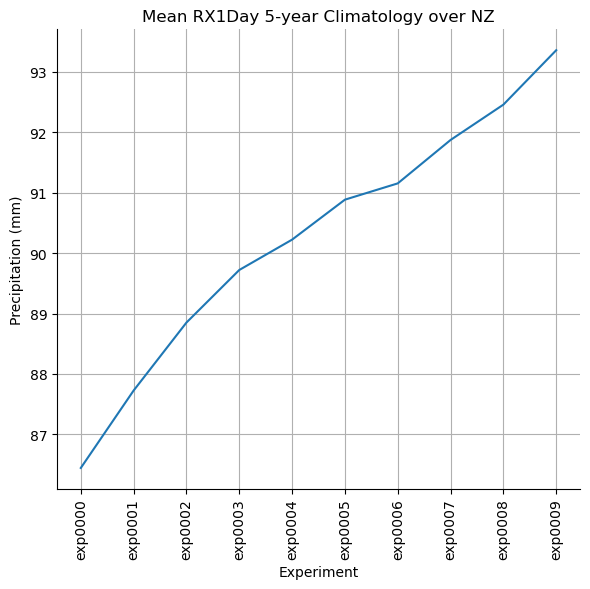

In [103]:
fig, ax = plt.subplots(figsize = (6, 6))
dset.where(orog>0, np.nan).mean(["lat","lon"]).pr.plot(ax = ax)
ax.tick_params(axis='x', rotation=90)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel("Precipitation (mm)")
ax.set_xlabel("Experiment")
ax.set_title("Mean RX1Day 5-year Climatology over NZ", fontsize=12)
ax.grid('on')
plt.tight_layout()
fig.show()
fig.savefig(r'/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/GCM_emulator/figures/rx1day.png', dpi =300, bbox_inches ='tight')

In [56]:
preds.sel(exp = 'exp0000').mean(["lat","lon"]).pr.argmax()

<xarray.DataArray 'pr' ()>
array(1554)
Coordinates:
    GCM      <U10 'ACCESS-CM2'
    exp      <U7 'exp0000'

In [65]:
preds.isel(time =1554).max(["lat","lon"])

<xarray.Dataset>
Dimensions:      (exp: 10)
Coordinates:
  * exp          (exp) <U7 'exp0000' 'exp0001' 'exp0002' ... 'exp0008' 'exp0009'
    GCM          <U10 'ACCESS-CM2'
    time         object 2099-04-05 12:00:00
Data variables:
    pr           (exp) float64 193.5 207.0 220.3 227.0 ... 238.4 235.6 242.2
    pr_GAN_mask  (exp) int64 0 0 0 0 0 0 0 0 0 0

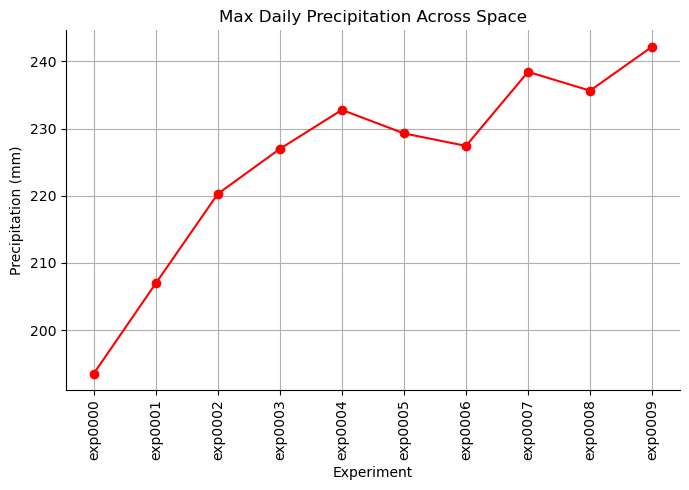

In [100]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 5))

# Plot the maximum precipitation across space
preds.isel(time=1554).max(["lat", "lon"]).pr.plot(ax=ax, marker ='o', color ='r')

# Improve plot appearance
ax.tick_params(axis='x', rotation=90)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel("Precipitation (mm)")
ax.set_xlabel("Experiment")
ax.set_title("Max Daily Precipitation Across Space", fontsize=12)
ax.grid('on')
plt.tight_layout()

fig.savefig('/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/GCM_emulator/figures/precipitation_for_a_case_study_max_precip.png', dpi =300, bbox_inches ='tight')

plt.show()

In [95]:
preds.sel(exp=exp).isel(time=1554)

<xarray.Dataset>
Dimensions:      (lat: 172, lon: 179)
Coordinates:
    exp          <U7 'exp0009'
  * lon          (lon) float32 164.9 165.0 165.1 165.2 ... 183.7 183.9 184.0
  * lat          (lat) float32 -51.21 -51.11 -51.0 ... -33.07 -32.97 -32.86
    GCM          <U10 'ACCESS-CM2'
    time         object 2099-04-05 12:00:00
Data variables:
    pr           (lat, lon) float64 1.138 1.22 1.186 1.266 ... 0.0 0.1344 0.0
    pr_GAN_mask  (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
Attributes: (12/28)
    CDI:             Climate Data Interface version 1.9.5 (http://mpimet.mpg....
    history:         Tue Mar 12 14:54:26 2024: cdo merge /nesi/project/niwa00...
    source:          CSIRO conformal-cubic model. Input file: surf.ccam_12km....
    Conventions:     CF-1.7
    title:           CCAM simulation data
    il:              288
    ...              ...
    BC_version:      no output bias correction
    CMOR_v:          v1.0 Public
    CDO_call:        daymean computed on hourly data
    project:         NIWA CMIP6 Downscaling
    contact:         Peter Gibson (peter.gibson@niwa.co.nz)
    CDO:             Climate Data Operators version 1.9.5 (http://mpimet.mpg....

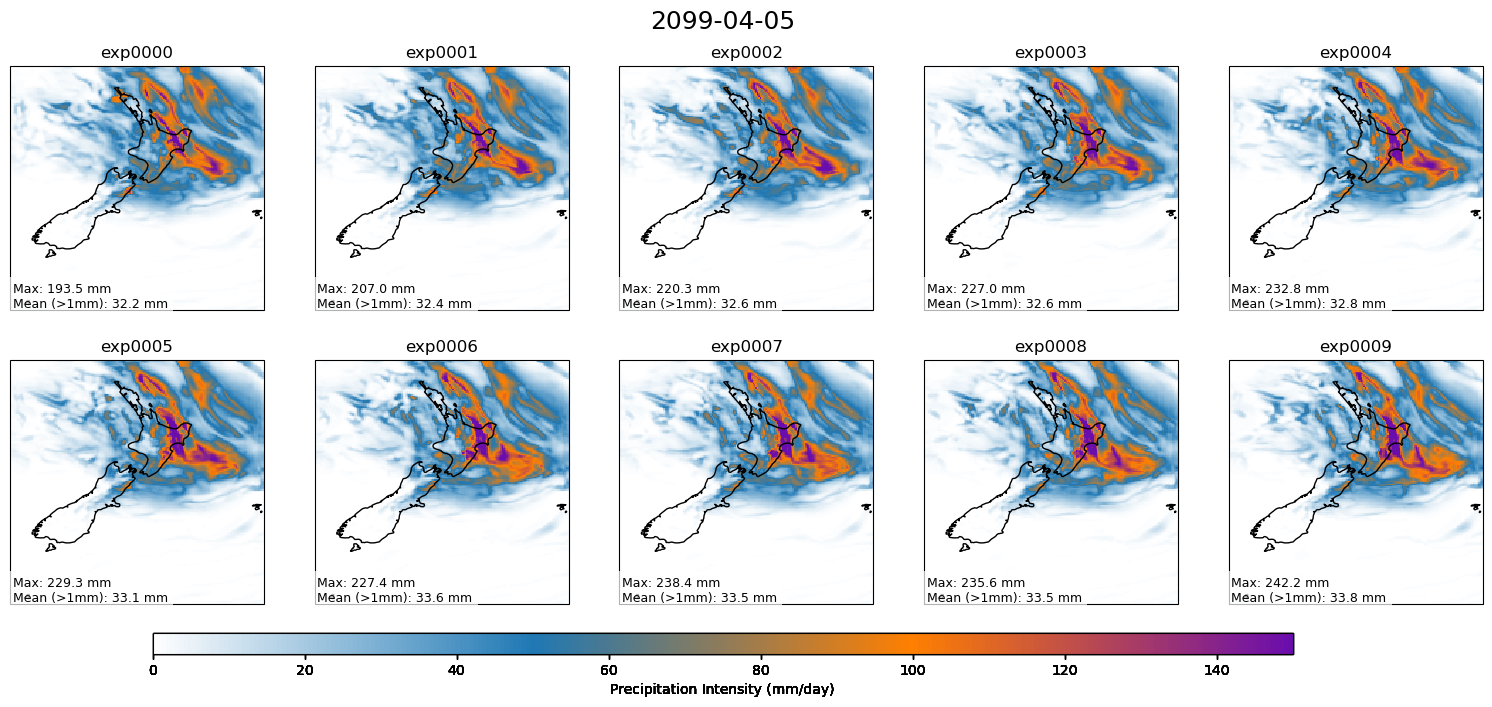

In [99]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.colors as mcolors
import numpy as np

# Define a custom colormap: white (low) → blue → orange → purple (high)
colors = ["#ffffff", "#1f78b4", "#ff7f00", "#6a0dad"]  # white, blue, orange, purple
cmap = mcolors.LinearSegmentedColormap.from_list("white_blue_orange_purple", colors)

# Create the facet plot
fig, axes = plt.subplots(
    nrows=2, ncols=5,
    figsize=(19, 7),
    subplot_kw={'projection': ccrs.PlateCarree(central_longitude=171.77)}
)

axes = axes.flatten()

# Loop over experiments
for i, exp in enumerate(preds.exp.values):
    data = preds.sel(exp=exp).isel(time=1554).pr
    pr_values = data.values

    # Compute max and mean (where pr > 1 mm/day)
    max_pr = np.nanmax(pr_values)
    mean_pr = np.nanmean(pr_values[pr_values > 1.0])

    # Plot the data
    im = data.plot(
        ax=axes[i],
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        vmax=150,
        add_colorbar=False,
    )
    axes[i].coastlines()
    axes[i].set_title(str(exp))

    # Annotate statistics
    axes[i].text(
        0.01, 0.01,
        f"Max: {max_pr:.1f} mm\nMean (>1mm): {mean_pr:.1f} mm",
        transform=axes[i].transAxes,
        fontsize=9,
        color='black',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
    cbarax=fig.add_axes([0.2, 0.04, 0.6, 0.03])
    cbar = fig.colorbar(im, cax = cbarax, orientation ='horizontal')
    cbar.set_label('Precipitation Intensity (mm/day)')
    fig.suptitle('2099-04-05', x =0.5, y=0.96, fontsize =18)
    fig.savefig('/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/GCM_emulator/figures/precipitation_for_a_case_study.png', dpi =300, bbox_inches ='tight')


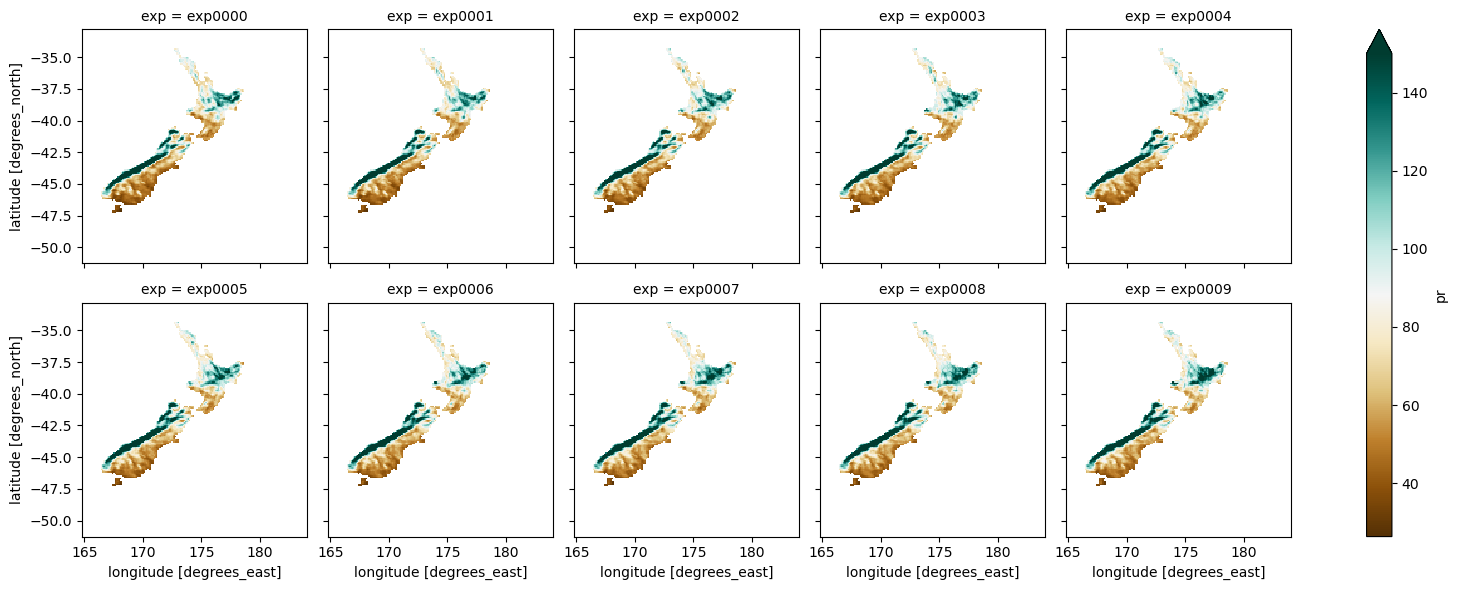

In [50]:
dset.pr.where(orog>0, np.nan).plot(col ="exp", col_wrap =5, vmax =150, cmap ='BrBG')

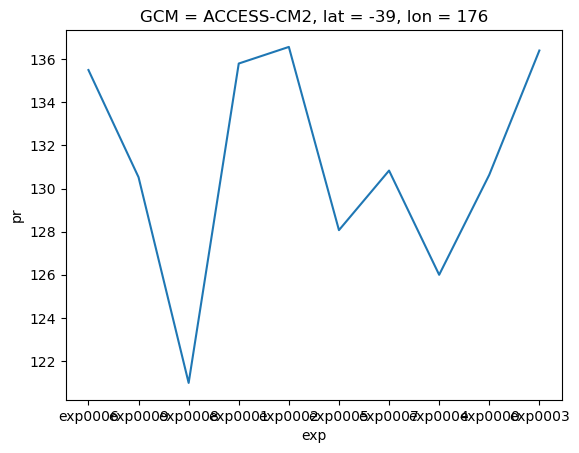

In [31]:
rx1day.interp(lat =-39, lon =176, method ='nearest').pr.plot()

In [25]:

# PREP OUTPUT

with ProgressBar():
    mean_data = mean_data.load()
    variance_data = variance_data.load()
    processed_GCM_data = processed_GCM_data.load()
    time_of_year = time_of_year.load()
    print(mean_data, time_of_year)
print('PREP OUTPUT')
output_shape = initialize_output_ds(processed_GCM_data, config)
output_shape = output_shape.rename({"pr": variable})


<xarray.DataArray 'q_500' (channel: 8, time: 31411)>
array([[ 4.5549873e-01, -2.3507118e-02,  4.5244321e-01, ...,
         1.5300345e+00,  2.4468446e+00,  3.6205027e+00],
       [ 2.1126568e-01, -2.6527923e-01, -3.0036268e-01, ...,
         1.9098775e+00,  2.5087149e+00,  3.3172333e+00],
       [ 3.1234252e-01,  2.5087810e-01,  2.7895106e-02, ...,
        -2.0575432e-01, -5.8768141e-01, -9.0680468e-01],
       ...,
       [ 3.4481615e-01,  1.1446120e+00,  8.0104285e-01, ...,
         3.8201907e-01, -7.0132202e-01, -2.1661975e+00],
       [ 8.4645584e-02, -1.4468497e-01, -1.1675495e-03, ...,
         1.5886772e+00,  1.7362022e+00,  2.1141305e+00],
       [ 9.1751933e-01,  7.4371672e-01,  7.0101881e-01, ...,
         5.0441068e-01,  1.0654876e+00,  1.9273919e+00]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01T12:00:00 ... 2100-12-31T12:00:00
  * channel  (channel) <U5 'q_500' 'q_850' 'u_500' ... 'v_850' 't_500' 't_850' <xarray.DataArray 'dayofyear' (time: 314

In [26]:
# APPLY MODEL
print('APPLY ML MODEL')
ts = slice("2015","2040")
output2 = predict_parallel_resid_corrector_v5varname(generator, unet_model,
                                                    processed_GCM_data.transpose('time', 'lat', 'lon',
                                                                                 'channel').sel(time = ts).values, \
                                                    output_shape.sel(time = ts), 64, orog, output_means, output_stds, time_of_year.sel(time = ts), \
                                                    mean_data.sel(time = ts).transpose('time', 'channel'),
                                                    variance_data.sel(time = ts).transpose('time', 'channel'), gan=GAN_flag, \
                                                    min_value=min_value, varname=variable)



APPLY ML MODEL


Predicting:   0%|          | 0/148 [00:00<?, ?batch/s]2025-06-03 02:23:37.415334: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2025-06-03 02:23:37.424367: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2400000000 Hz
2025-06-03 02:23:38.215724: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2025-06-03 02:23:38.626151: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2025-06-03 02:23:40.335474: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2025-06-03 02:23:40.576855: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
Predicting: 100%|██████████| 148/148 [03:26<00:00,  1.39s/batch]


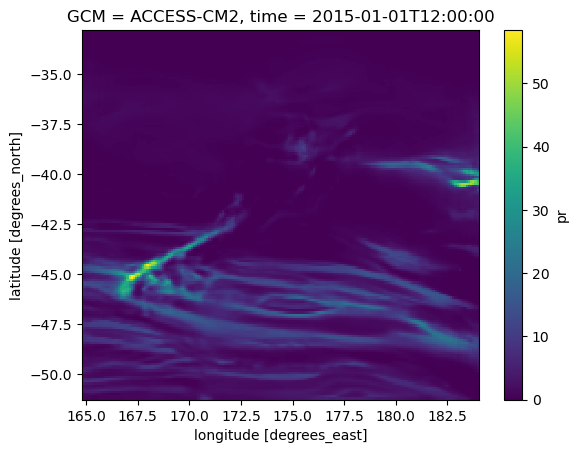

In [43]:
output2.isel(time =0).pr.plot()

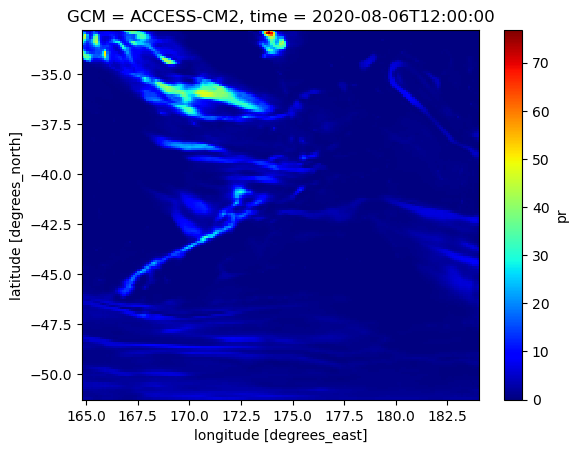

In [244]:
output2.isel(time =-148).pr.plot(cmap ='jet')

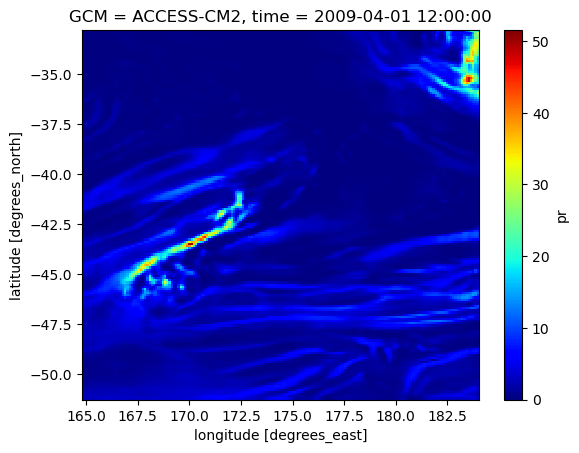

In [237]:
output.isel(time =1185).pr.plot(cmap ='jet')

In [69]:
climo = output.groupby('time.season').mean()

In [173]:
climo2 = output2.groupby('time.season').mean()

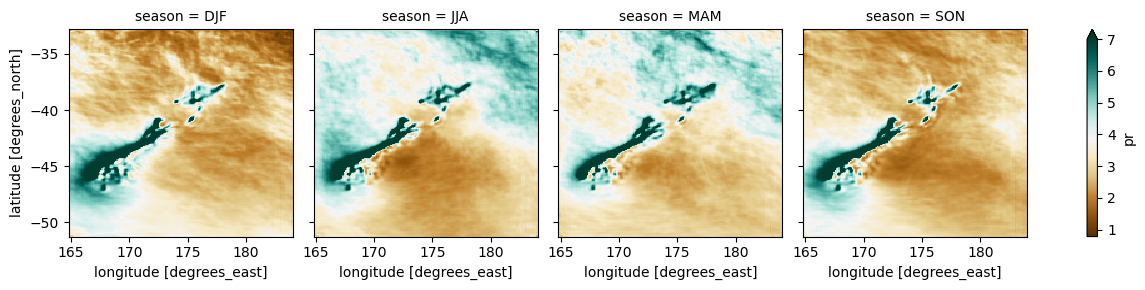

In [174]:
climo2.pr.plot(col ="season", vmax =7, cmap ='BrBG')

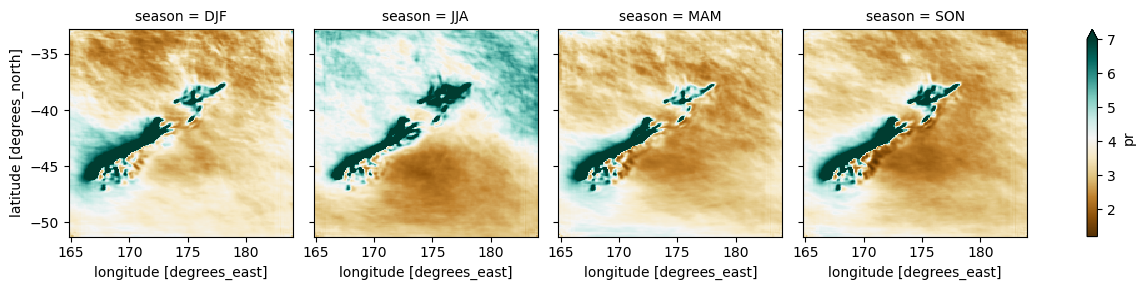

In [70]:
climo.pr.plot(col ="season", vmax =7, cmap ='BrBG')